## Notebook that calculates polynya area from thermal imagery
Uses effective MODIS pixel dimension that varies depending on zenith view angles (i.e., scene-dependent). Sensitivity analysis included where each polynya category (total, west, east, etc.) also has an upper and lower bound (e.g., utotal, ltotal) based on thresholds that are +/- 1 deg C from scene dependnt temperature threshold. See manuscript for details.

Elena Savidge
<br>
3 Aug 2023

In [430]:
import matplotlib.pyplot as plt
import cartopy
import xarray as xr
import cmocean
from pyhdf.SD import SD, SDC
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import pyproj
from pyproj import Proj, transform, CRS
from glob import glob
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, Polygon
import geopandas as gpd
import scipy
from scipy import ndimage
from cartopy.geodesic import Geodesic
import datetime

In [431]:
# NOTE: need dir to be set up this way for pyproj to work
pyproj.datadir.set_data_dir('/opt/anaconda3/envs/sealenv/share/proj') 

/opt/anaconda3/envs/polyarea/lib/python3.11/site-packages/pyproj/datadir.py:38: UserWarning: pyproj unable to set database path.
  _global_context_set_data_dir()


In [432]:
pwd

'/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/polynyatimeseries'

In [4]:
#cd ../PhD_Ch2/polynyatimeseries

/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/polynyatimeseries


### Calculate haversine distance in km between lat bounds and lon bouds
#### 1. Define function

In [433]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    return km

#### 2. Plot test image to visualize lat/lon bounds (defined with: llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 in second cell)

In [196]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200602/MOD09.A2020154.1410.006.2020156021206.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

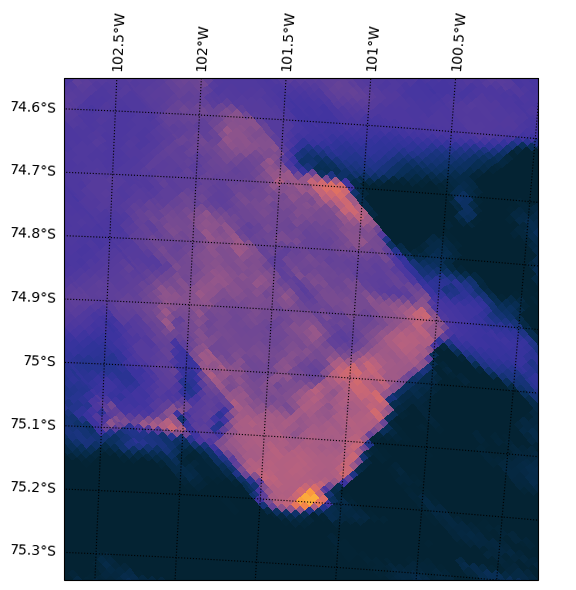

In [7]:
# Plot
llcrnrlat=-75.3;urcrnrlat=-74.55;llcrnrlon=-102.7;urcrnrlon=-100 

fig,ax = plt.subplots(figsize=(6,6)) # give two axes 

plt.axis('off')
m = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=-105.0))
m.set_extent([llcrnrlon, urcrnrlon, llcrnrlat, urcrnrlat], ccrs.PlateCarree())
gl = m.gridlines(draw_labels=True,xlocs=[-102.5,-102,-101.5,-101,-100.5,-100],ylocs=[-75.3,-75.2,-75.1,-75,-74.9,-74.8,-74.7,-74.6,-74.5],y_inline=False,color='k',linestyle=':')
gl.bottom_labels = gl.right_labels =  False

#data = m.pcolormesh(lon250,lat250,B1,transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=0,vmax=10000)
data = m.pcolormesh(lon,lat,B31,transform=ccrs.PlateCarree(),cmap=cmocean.cm.thermal,vmin=-30,vmax=0)

#cb = plt.colorbar(data,fraction=0.045,pad=0.025,orientation='horizontal')#,shrink=0.84)
#plt.savefig('Dpanel.png', format='png',  bbox_inches="tight",dpi=400)

plt.tight_layout()

## Run through all visible images
### Define 3 required functions

#### Function 1: extracts modis lat, lon, DN and subsets fig (with constrained coordinate bounds) into store xarray

In [434]:
def modis_to_xarray(longitude,latitude,bandvals):
    
    '''Extracts modis lat, lon, B31 and subsets figure into xarray'''
    
    # Convert input data from pandas dataframe to xarray dataArray for easier use and less memory intensive
    data_xr = xr.DataArray(bandvals,dims=["y","x"], coords={"latitude": (["y", "x"],latitude), "longitude": (["y", "x"],longitude)})
    
    # Subset entire modis image to PIG bounds and store output for area calc fct
    figure_bounds = data_xr.where((data_xr.longitude>-102.7)&(data_xr.longitude<-100) & (data_xr.latitude>-75.3)&(data_xr.latitude<-74.55),drop=True)

    #return data_xr
    return figure_bounds

#### Function 2: Calculate effective pixel size to be input into fct 3 call

In [435]:
def effectivepixel(figure_bounds):
    
    '''Calculates effective avg pixel sixe within individual scene'''
    
    # these are image corners, with y positive down, which doesn't really matter
    # for our purposes but can get confusing nonetheless
    upperleft = figure_bounds[0,0]
    upperright = figure_bounds[0,-1]
    lowerleft = figure_bounds[-1,0]
    lowerright = figure_bounds[-1,-1]

    # calculate the length of each side of the image based on the corner coordinates
    top_len = haversine_np(upperleft.longitude.values, upperleft.latitude.values,
                           upperright.longitude.values, upperright.latitude.values)
    bottom_len = haversine_np(lowerleft.longitude.values, lowerleft.latitude.values,
                              lowerright.longitude.values, lowerright.latitude.values)
    left_len = haversine_np(upperleft.longitude.values, upperleft.latitude.values,
                            lowerleft.longitude.values, lowerleft.latitude.values)
    right_len = haversine_np(upperright.longitude.values, upperright.latitude.values,
                             lowerright.longitude.values, lowerright.latitude.values)
    
    # divide through by the number of pixels to get the effective pixel size for each side
    eff_pixel_top = top_len/len(figure_bounds.x)
    eff_pixel_bottom = bottom_len/len(figure_bounds.x)
    eff_pixel_left = left_len/len(figure_bounds.y)
    eff_pixel_right = right_len/len(figure_bounds.y)
    
    # take the mean of the top and bottom sides for the average pixel width
    # and the mean of the left and right sides for the average pixel height
    avgpixelwidth = (eff_pixel_top + eff_pixel_bottom)/2
    avgpixelheight = (eff_pixel_left + eff_pixel_right)/2
    
    return avgpixelwidth,avgpixelheight 

#### Function 3: calculates polynya area by location (west, mid, east, other).
Only edits from visible imagery function:
- Pixel size (1 km instead of 250 m)
- Sign (>=) thresh is opposite b/c temp cutoff is negative (e.g., -11 dec C here)

In [436]:
def polynya_mask(fig_bounds, westpoint, midpoint, eastpoint, pixelwidth, pixelheight, thresh = None):
    
    '''Calculates polynya area by type (east [e], west [w], mid [m], other [o]) and total [tot].
    This fct is based on radius search area from lat,lon point
    
    This version uses xarray instead od pd.Dataframe to make more effcicient'''

    # distance (radius) from point method 
    # convert lat, lon to radians
    # x, y center points polynya
    lat_w = westpoint[0]; lon_w = westpoint[1]; # west polynya center lat, lon
    lat_e = eastpoint[0]; lon_e = eastpoint[1]; #east
    lat_m = midpoint[0]; lon_m = midpoint[1]; # mid

    # convert lats, lons to radians for distance calc
    modislat_rad = np.radians(figure_bounds.latitude)
    modislon_rad = np.radians(figure_bounds.longitude)

    # target points of polynyas (east, west, mid) -- can be approx for now as we'll look in a multiple km search area
    targetlat_rad_e = np.radians(lat_e); targetlon_rad_e = np.radians(lon_e)
    targetlat_rad_w = np.radians(lat_w); targetlon_rad_w = np.radians(lon_w)
    targetlat_rad_m = np.radians(lat_m); targetlon_rad_m = np.radians(lon_m)

    # haversine dist calc, by polynya 
    a_e = np.sin((targetlat_rad_e-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_e) * np.sin((targetlon_rad_e-modislon_rad)/2.0)**2

    a_w = np.sin((targetlat_rad_w-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_w) * np.sin((targetlon_rad_w-modislon_rad)/2.0)**2

    a_m = np.sin((targetlat_rad_m-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_m) * np.sin((targetlon_rad_m-modislon_rad)/2.0)**2

    # calc dist search area in km for each polynya
    earth_radius = 6371 #km
    distkm_e = earth_radius * 2 * np.arcsin(np.sqrt(a_e)) #km
    distkm_w = earth_radius * 2 * np.arcsin(np.sqrt(a_w)) #km
    distkm_m = earth_radius * 2 * np.arcsin(np.sqrt(a_m)) #km

    # will need diff dist thresh for each polynya
    dist_thresh_e = 12 # km
    dist_thresh_w = 12 # km
    dist_thresh_m = 6.5 # km
    east_bounds = figure_bounds.where(distkm_e < dist_thresh_e, drop=True)
    west_bounds = figure_bounds.where(distkm_w < dist_thresh_w, drop=True)
    middle_bounds = figure_bounds.where(distkm_m < dist_thresh_m, drop=True)

    # ADD ERROR HERE
    # Define DN threshold and modis pixel size
    thresh = thresh; 
    u_thresh = thresh - 1 
    l_thresh = thresh + 1
    pixelarea = pixelwidth*pixelheight; # in km2 #effective pixel now

    # Create polynya mask for each type based on threshold
    mask_w = west_bounds.where(west_bounds>=thresh)
    mask_e = east_bounds.where(east_bounds>=thresh)
    mask_m = middle_bounds.where(middle_bounds>=thresh)
    mask_total = figure_bounds.where(figure_bounds>=thresh)
    
    u_mask_w = west_bounds.where(west_bounds>=u_thresh)
    u_mask_e = east_bounds.where(east_bounds>=u_thresh)
    u_mask_m = middle_bounds.where(middle_bounds>=u_thresh)
    u_mask_total = figure_bounds.where(figure_bounds>=u_thresh)
    
    l_mask_w = west_bounds.where(west_bounds>=l_thresh)
    l_mask_e = east_bounds.where(east_bounds>=l_thresh)
    l_mask_m = middle_bounds.where(middle_bounds>=l_thresh)
    l_mask_total = figure_bounds.where(figure_bounds>=l_thresh)

    # Calculate area (km2) of all polynya types and total area 
    area_w = (mask_w.count()) * pixelarea 
    area_e = (mask_e.count()) * pixelarea 
    area_m = (mask_m.count()) * pixelarea 
    area_tot = (mask_total.count()) * pixelarea # in km2
    
    u_area_w = (u_mask_w.count()) * pixelarea 
    u_area_e = (u_mask_e.count()) * pixelarea 
    u_area_m = (u_mask_m.count()) * pixelarea 
    u_area_tot = (u_mask_total.count()) * pixelarea # in km2
    
    l_area_w = (l_mask_w.count()) * pixelarea 
    l_area_e = (l_mask_e.count()) * pixelarea 
    l_area_m = (l_mask_m.count()) * pixelarea 
    l_area_tot = (l_mask_total.count()) * pixelarea # in km2

    # other = total mask minus all polynya
    area_o = area_tot - (area_w + area_e + area_m) # km2
    
    u_area_o = u_area_tot - (u_area_w + u_area_e + u_area_m) # km2
        
    l_area_o = l_area_tot - (l_area_w + l_area_e + l_area_m) # km2

    # Store all values in horizontal vector and add date (format 'yyyymmdd')
    area = np.array([area_w,area_e,area_m,area_o,area_tot,u_area_w,u_area_e,u_area_m,u_area_o,u_area_tot,l_area_w,
                     l_area_e,l_area_m,l_area_o,l_area_tot,pixelwidth,pixelheight])

    # Create dataframe that stores these vals 
    area_df = pd.DataFrame(area)
    area_df = area_df.T
    area_df.columns = ['west','east', 'mid','other','total','uwest','ueast', 'umid','uother','utotal',
                      'lwest','least', 'lmid','lother','ltotal','pixelwidth','pixelheight']
    return area_df

    # Delete excessive variables
    del modislat_rad,modislon_rad,targetlat_rad_e,targetlat_rad_w,targetlat_rad_m,a_e,a_w,a_m,distkm_e,distkm_w,distkm_m,east_bounds,west_bounds,middle_bounds, \
        mask_w,mask_e,mask_m,mask_total

## Run through all thermal scenes

#### Define search center coords for 2022

In [437]:
# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2022 = [-75.155,-101.32]
m2022 = [-75.01, -101.00]
e2022 = [-74.87,-100.66]

## 2020/06/02

In [438]:
# Make list of all MOD09 files in folder
MODfiles = glob('20200602/MOD09.A2020154.1410.006.2020156021206.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [440]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20200602 = polynya_mask(figure_bounds, w2022, m2022, e2022, width, height, thresh=-11) 
area_20200602['Date'] = '20200602' # Add date
area_20200602

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.605105,0.0,0.0,0.0,9.605105,12.006382,0.0,0.0,3.601915,15.608296,7.203829,0.0,0.0,0.0,7.203829,1.220839,0.983453,20200602


## 2018/08/02

In [441]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2018 = [-75.065,-101.77]
m2018 = [-74.99, -101.19]
e2018 = [-74.895,-100.66]

In [442]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180802/MOD09.A2018214.1400.006.2018216023621.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [443]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180802 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-30) 
area_20180802['Date'] = '20180802' # Add date
area_20180802

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.937269,0.0,0.0,0.0,8.937269,10.214022,0.0,0.0,0.0,10.214022,5.107011,0.0,0.0,0.0,5.107011,1.300759,0.981545,20180802


In [444]:
# concat into df as we go through scenes
df_concat = pd.concat([area_20200602,area_20180802])
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.605105,0.0,0.0,0.0,9.605105,12.006382,0.0,0.0,3.601915,15.608296,7.203829,0.0,0.0,0.0,7.203829,1.220839,0.983453,20200602
0,8.937269,0.0,0.0,0.0,8.937269,10.214022,0.0,0.0,0.000000,10.214022,5.107011,0.0,0.0,0.0,5.107011,1.300759,0.981545,20180802


## 2018/08/01

In [445]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180801/MOD09.A2018213.1455.006.2018215210911.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [446]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180801 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-30) 
area_20180801['Date'] = '20180801' # Add date
area_20180801

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,18.367829,0.0,0.0,0.0,18.367829,19.388264,0.0,0.0,0.0,19.388264,17.347394,0.0,0.0,0.0,17.347394,1.0308,0.989945,20180801


In [447]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180801])
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.605105,0.0,0.0,0.0,9.605105,12.006382,0.0,0.0,3.601915,15.608296,7.203829,0.0,0.0,0.0,7.203829,1.220839,0.983453,20200602
0,8.937269,0.0,0.0,0.0,8.937269,10.214022,0.0,0.0,0.000000,10.214022,5.107011,0.0,0.0,0.0,5.107011,1.300759,0.981545,20180802
0,18.367829,0.0,0.0,0.0,18.367829,19.388264,0.0,0.0,0.000000,19.388264,17.347394,0.0,0.0,0.0,17.347394,1.030800,0.989945,20180801


## 2018/07/31

In [448]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180731/MOD09.A2018212.1550.006.2018214023411.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [449]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180731 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-26) 
area_20180731['Date'] = '20180731' # Add date
area_20180731

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,26.56169,0.0,0.0,0.0,26.56169,31.391088,0.0,0.0,9.658796,41.049884,26.56169,0.0,0.0,0.0,26.56169,1.218558,0.990801,20180731


In [450]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180731])
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.605105,0.0,0.0,0.0,9.605105,12.006382,0.0,0.0,3.601915,15.608296,7.203829,0.0,0.0,0.0,7.203829,1.220839,0.983453,20200602
0,8.937269,0.0,0.0,0.0,8.937269,10.214022,0.0,0.0,0.000000,10.214022,5.107011,0.0,0.0,0.0,5.107011,1.300759,0.981545,20180802
0,18.367829,0.0,0.0,0.0,18.367829,19.388264,0.0,0.0,0.000000,19.388264,17.347394,0.0,0.0,0.0,17.347394,1.030800,0.989945,20180801
0,26.561690,0.0,0.0,0.0,26.561690,31.391088,0.0,0.0,9.658796,41.049884,26.561690,0.0,0.0,0.0,26.561690,1.218558,0.990801,20180731


## 2018/07/30

In [451]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180730/MYD09.A2018211.2220.061.2021338093326.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [452]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180730 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-28) 
area_20180730['Date'] = '20180730' # Add date
area_20180730

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.421619,0.0,0.0,0.0,23.421619,34.623262,0.0,0.0,27.494943,62.118206,20.366625,0.0,0.0,0.0,20.366625,1.028857,0.98977,20180730


In [453]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180730])
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.605105,0.0,0.0,0.0,9.605105,12.006382,0.0,0.0,3.601915,15.608296,7.203829,0.0,0.0,0.0,7.203829,1.220839,0.983453,20200602
0,8.937269,0.0,0.0,0.0,8.937269,10.214022,0.0,0.0,0.000000,10.214022,5.107011,0.0,0.0,0.0,5.107011,1.300759,0.981545,20180802
0,18.367829,0.0,0.0,0.0,18.367829,19.388264,0.0,0.0,0.000000,19.388264,17.347394,0.0,0.0,0.0,17.347394,1.030800,0.989945,20180801
0,26.561690,0.0,0.0,0.0,26.561690,31.391088,0.0,0.0,9.658796,41.049884,26.561690,0.0,0.0,0.0,26.561690,1.218558,0.990801,20180731
0,23.421619,0.0,0.0,0.0,23.421619,34.623262,0.0,0.0,27.494943,62.118206,20.366625,0.0,0.0,0.0,20.366625,1.028857,0.989770,20180730


## 2018/07/29

In [454]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180729/MYD09.A2018210.2315.061.2021338091201.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [455]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180729 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-24) 
area_20180729['Date'] = '20180729' # Add date
area_20180729

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,26.615097,0.0,0.0,0.0,26.615097,40.501235,13.886138,23.143563,2.314356,79.845291,24.300741,0.0,0.0,0.0,24.300741,1.174876,0.984936,20180729


In [456]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180729])
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.605105,0.0,0.0,0.0,9.605105,12.006382,0.000000,0.000000,3.601915,15.608296,7.203829,0.0,0.0,0.0,7.203829,1.220839,0.983453,20200602
0,8.937269,0.0,0.0,0.0,8.937269,10.214022,0.000000,0.000000,0.000000,10.214022,5.107011,0.0,0.0,0.0,5.107011,1.300759,0.981545,20180802
0,18.367829,0.0,0.0,0.0,18.367829,19.388264,0.000000,0.000000,0.000000,19.388264,17.347394,0.0,0.0,0.0,17.347394,1.030800,0.989945,20180801
0,26.561690,0.0,0.0,0.0,26.561690,31.391088,0.000000,0.000000,9.658796,41.049884,26.561690,0.0,0.0,0.0,26.561690,1.218558,0.990801,20180731
0,23.421619,0.0,0.0,0.0,23.421619,34.623262,0.000000,0.000000,27.494943,62.118206,20.366625,0.0,0.0,0.0,20.366625,1.028857,0.989770,20180730
0,26.615097,0.0,0.0,0.0,26.615097,40.501235,13.886138,23.143563,2.314356,79.845291,24.300741,0.0,0.0,0.0,24.300741,1.174876,0.984936,20180729


## 2018/07/28

In [457]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180728/MOD09.A2018209.1520.006.2018211023358.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [458]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180728 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-24) 
area_20180728['Date'] = '20180728' # Add date
area_20180728

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,24.751578,0.0,0.0,0.0,24.751578,28.876841,4.125263,0.0,86.630522,119.632625,23.720262,0.0,0.0,0.0,23.720262,1.043739,0.988098,20180728


In [459]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180728])
df_concat

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,9.605105,0.0,0.0,0.0,9.605105,12.006382,0.000000,0.000000,3.601915,15.608296,7.203829,0.0,0.0,0.0,7.203829,1.220839,0.983453,20200602
0,8.937269,0.0,0.0,0.0,8.937269,10.214022,0.000000,0.000000,0.000000,10.214022,5.107011,0.0,0.0,0.0,5.107011,1.300759,0.981545,20180802
0,18.367829,0.0,0.0,0.0,18.367829,19.388264,0.000000,0.000000,0.000000,19.388264,17.347394,0.0,0.0,0.0,17.347394,1.030800,0.989945,20180801
0,26.561690,0.0,0.0,0.0,26.561690,31.391088,0.000000,0.000000,9.658796,41.049884,26.561690,0.0,0.0,0.0,26.561690,1.218558,0.990801,20180731
0,23.421619,0.0,0.0,0.0,23.421619,34.623262,0.000000,0.000000,27.494943,62.118206,20.366625,0.0,0.0,0.0,20.366625,1.028857,0.989770,20180730
0,26.615097,0.0,0.0,0.0,26.615097,40.501235,13.886138,23.143563,2.314356,79.845291,24.300741,0.0,0.0,0.0,24.300741,1.174876,0.984936,20180729
0,24.751578,0.0,0.0,0.0,24.751578,28.876841,4.125263,0.000000,86.630522,119.632625,23.720262,0.0,0.0,0.0,23.720262,1.043739,0.988098,20180728


## 2018/07/27

In [460]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180727/MYD09.A2018208.2150.061.2021337033927.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [461]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180727 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-21) 
area_20180727['Date'] = '20180727' # Add date
area_20180727

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,27.484123,0.0,0.0,0.0,27.484123,30.919639,0.0,0.0,32.06481,62.984449,25.19378,0.0,0.0,0.0,25.19378,1.164357,0.983523,20180727


In [462]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180727])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,26.561690,0.0,0.0,0.0,26.561690,31.391088,0.000000,0.000000,9.658796,41.049884,26.561690,0.0,0.0,0.0,26.561690,1.218558,0.990801,20180731
0,23.421619,0.0,0.0,0.0,23.421619,34.623262,0.000000,0.000000,27.494943,62.118206,20.366625,0.0,0.0,0.0,20.366625,1.028857,0.989770,20180730
0,26.615097,0.0,0.0,0.0,26.615097,40.501235,13.886138,23.143563,2.314356,79.845291,24.300741,0.0,0.0,0.0,24.300741,1.174876,0.984936,20180729
0,24.751578,0.0,0.0,0.0,24.751578,28.876841,4.125263,0.000000,86.630522,119.632625,23.720262,0.0,0.0,0.0,23.720262,1.043739,0.988098,20180728
0,27.484123,0.0,0.0,0.0,27.484123,30.919639,0.000000,0.000000,32.064810,62.984449,25.193780,0.0,0.0,0.0,25.193780,1.164357,0.983523,20180727


## 2018/07/22

In [463]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180722/MYD09.A2018203.2130.006.2018206154528.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [464]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180722 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-27) 
area_20180722['Date'] = '20180722' # Add date
area_20180722

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,30.566747,0.0,0.0,0.0,30.566747,35.882703,0.0,0.0,0.0,35.882703,29.237758,0.0,0.0,0.0,29.237758,1.344528,0.988443,20180722


In [465]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180722])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,23.421619,0.0,0.0,0.0,23.421619,34.623262,0.000000,0.000000,27.494943,62.118206,20.366625,0.0,0.0,0.0,20.366625,1.028857,0.989770,20180730
0,26.615097,0.0,0.0,0.0,26.615097,40.501235,13.886138,23.143563,2.314356,79.845291,24.300741,0.0,0.0,0.0,24.300741,1.174876,0.984936,20180729
0,24.751578,0.0,0.0,0.0,24.751578,28.876841,4.125263,0.000000,86.630522,119.632625,23.720262,0.0,0.0,0.0,23.720262,1.043739,0.988098,20180728
0,27.484123,0.0,0.0,0.0,27.484123,30.919639,0.000000,0.000000,32.064810,62.984449,25.193780,0.0,0.0,0.0,25.193780,1.164357,0.983523,20180727
0,30.566747,0.0,0.0,0.0,30.566747,35.882703,0.000000,0.000000,0.000000,35.882703,29.237758,0.0,0.0,0.0,29.237758,1.344528,0.988443,20180722


## 2018/06/29

In [466]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180629/MOD09.A2018180.1550.006.2018182022747.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [467]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180629 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-28) 
area_20180629['Date'] = '20180629' # Add date
area_20180629

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,30.196011,0.0,0.0,0.0,30.196011,37.443053,0.0,0.0,20.533287,57.97634,25.364649,0.0,0.0,0.0,25.364649,1.219097,0.990766,20180629


In [468]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180629])

## 2018/06/28

In [469]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180628/MYD09.A2018179.2220.006.2018181020433.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [470]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180628 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-29) 
area_20180628['Date'] = '20180628' # Add date
area_20180628

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,40.773014,0.0,0.0,0.0,40.773014,68.294798,0.0,0.0,13.25123,81.546028,32.618411,0.0,0.0,0.0,32.618411,1.031967,0.98775,20180628


In [471]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180628])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,24.751578,0.0,0.0,0.0,24.751578,28.876841,4.125263,0.0,86.630522,119.632625,23.720262,0.0,0.0,0.0,23.720262,1.043739,0.988098,20180728
0,27.484123,0.0,0.0,0.0,27.484123,30.919639,0.000000,0.0,32.064810,62.984449,25.193780,0.0,0.0,0.0,25.193780,1.164357,0.983523,20180727
0,30.566747,0.0,0.0,0.0,30.566747,35.882703,0.000000,0.0,0.000000,35.882703,29.237758,0.0,0.0,0.0,29.237758,1.344528,0.988443,20180722
0,30.196011,0.0,0.0,0.0,30.196011,37.443053,0.000000,0.0,20.533287,57.976340,25.364649,0.0,0.0,0.0,25.364649,1.219097,0.990766,20180629
0,40.773014,0.0,0.0,0.0,40.773014,68.294798,0.000000,0.0,13.251230,81.546028,32.618411,0.0,0.0,0.0,32.618411,1.031967,0.987750,20180628


## 2018/06/22

In [472]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180622/MOD09.A2018173.1405.006.2018175023631.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [473]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180622 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-25) 
area_20180622['Date'] = '20180622' # Add date
area_20180622

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.951367,0.0,0.0,0.0,62.951367,98.747243,0.0,0.0,43.201919,141.949161,45.6706,0.0,0.0,0.0,45.6706,1.256214,0.982588,20180622


In [474]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180622])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,27.484123,0.0,0.0,0.0,27.484123,30.919639,0.0,0.0,32.064810,62.984449,25.193780,0.0,0.0,0.0,25.193780,1.164357,0.983523,20180727
0,30.566747,0.0,0.0,0.0,30.566747,35.882703,0.0,0.0,0.000000,35.882703,29.237758,0.0,0.0,0.0,29.237758,1.344528,0.988443,20180722
0,30.196011,0.0,0.0,0.0,30.196011,37.443053,0.0,0.0,20.533287,57.976340,25.364649,0.0,0.0,0.0,25.364649,1.219097,0.990766,20180629
0,40.773014,0.0,0.0,0.0,40.773014,68.294798,0.0,0.0,13.251230,81.546028,32.618411,0.0,0.0,0.0,32.618411,1.031967,0.987750,20180628
0,62.951367,0.0,0.0,0.0,62.951367,98.747243,0.0,0.0,43.201919,141.949161,45.670600,0.0,0.0,0.0,45.670600,1.256214,0.982588,20180622


## 2018/06/04

In [475]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180604/MYD09.A2018155.2130.006.2018157024736.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [476]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180604 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-31) 
area_20180604['Date'] = '20180604' # Add date
area_20180604

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,42.673976,0.0,0.0,0.0,42.673976,84.01439,0.0,0.0,17.336303,101.350693,21.336988,0.0,0.0,0.0,21.336988,1.349562,0.988144,20180604


In [477]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180604])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,30.566747,0.0,0.0,0.0,30.566747,35.882703,0.0,0.0,0.000000,35.882703,29.237758,0.0,0.0,0.0,29.237758,1.344528,0.988443,20180722
0,30.196011,0.0,0.0,0.0,30.196011,37.443053,0.0,0.0,20.533287,57.976340,25.364649,0.0,0.0,0.0,25.364649,1.219097,0.990766,20180629
0,40.773014,0.0,0.0,0.0,40.773014,68.294798,0.0,0.0,13.251230,81.546028,32.618411,0.0,0.0,0.0,32.618411,1.031967,0.987750,20180628
0,62.951367,0.0,0.0,0.0,62.951367,98.747243,0.0,0.0,43.201919,141.949161,45.670600,0.0,0.0,0.0,45.670600,1.256214,0.982588,20180622
0,42.673976,0.0,0.0,0.0,42.673976,84.014390,0.0,0.0,17.336303,101.350693,21.336988,0.0,0.0,0.0,21.336988,1.349562,0.988144,20180604


## 2018/05/21

In [478]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180521/MOD09.A2018141.1405.006.2018143030827.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [479]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180521 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-26) 
area_20180521['Date'] = '20180521' # Add date
area_20180521

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,61.237197,0.0,0.0,0.0,61.237197,74.984322,21.245558,0.0,141.220474,237.450354,52.489026,0.0,0.0,0.0,52.489026,1.257904,0.993509,20180521


In [480]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180521])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,30.196011,0.0,0.0,0.0,30.196011,37.443053,0.000000,0.0,20.533287,57.976340,25.364649,0.0,0.0,0.0,25.364649,1.219097,0.990766,20180629
0,40.773014,0.0,0.0,0.0,40.773014,68.294798,0.000000,0.0,13.251230,81.546028,32.618411,0.0,0.0,0.0,32.618411,1.031967,0.987750,20180628
0,62.951367,0.0,0.0,0.0,62.951367,98.747243,0.000000,0.0,43.201919,141.949161,45.670600,0.0,0.0,0.0,45.670600,1.256214,0.982588,20180622
0,42.673976,0.0,0.0,0.0,42.673976,84.014390,0.000000,0.0,17.336303,101.350693,21.336988,0.0,0.0,0.0,21.336988,1.349562,0.988144,20180604
0,61.237197,0.0,0.0,0.0,61.237197,74.984322,21.245558,0.0,141.220474,237.450354,52.489026,0.0,0.0,0.0,52.489026,1.257904,0.993509,20180521


## 2018/05/17

In [481]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180517/MOD09.A2018137.1430.006.2018139021058.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [482]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180517 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-22) 
area_20180517['Date'] = '20180517' # Add date
area_20180517

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.81059,0.0,0.0,0.0,62.81059,76.033872,6.611641,0.0,15.427162,98.072675,55.097009,0.0,0.0,0.0,55.097009,1.110012,0.992729,20180517


In [483]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180517])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,40.773014,0.0,0.0,0.0,40.773014,68.294798,0.000000,0.0,13.251230,81.546028,32.618411,0.0,0.0,0.0,32.618411,1.031967,0.987750,20180628
0,62.951367,0.0,0.0,0.0,62.951367,98.747243,0.000000,0.0,43.201919,141.949161,45.670600,0.0,0.0,0.0,45.670600,1.256214,0.982588,20180622
0,42.673976,0.0,0.0,0.0,42.673976,84.014390,0.000000,0.0,17.336303,101.350693,21.336988,0.0,0.0,0.0,21.336988,1.349562,0.988144,20180604
0,61.237197,0.0,0.0,0.0,61.237197,74.984322,21.245558,0.0,141.220474,237.450354,52.489026,0.0,0.0,0.0,52.489026,1.257904,0.993509,20180521
0,62.810590,0.0,0.0,0.0,62.810590,76.033872,6.611641,0.0,15.427162,98.072675,55.097009,0.0,0.0,0.0,55.097009,1.110012,0.992729,20180517


## 2018/05/04

In [484]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180504/MOD09.A2018124.1500.006.2018126022926.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [485]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180504 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-25) 
area_20180504['Date'] = '20180504' # Add date
area_20180504

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,60.688544,0.0,0.0,0.0,60.688544,104.182,0.0,0.0,93.055767,197.237767,54.619689,0.0,0.0,0.0,54.619689,1.024964,0.986841,20180504


In [486]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180504])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.951367,0.0,0.0,0.0,62.951367,98.747243,0.000000,0.0,43.201919,141.949161,45.670600,0.0,0.0,0.0,45.670600,1.256214,0.982588,20180622
0,42.673976,0.0,0.0,0.0,42.673976,84.014390,0.000000,0.0,17.336303,101.350693,21.336988,0.0,0.0,0.0,21.336988,1.349562,0.988144,20180604
0,61.237197,0.0,0.0,0.0,61.237197,74.984322,21.245558,0.0,141.220474,237.450354,52.489026,0.0,0.0,0.0,52.489026,1.257904,0.993509,20180521
0,62.810590,0.0,0.0,0.0,62.810590,76.033872,6.611641,0.0,15.427162,98.072675,55.097009,0.0,0.0,0.0,55.097009,1.110012,0.992729,20180517
0,60.688544,0.0,0.0,0.0,60.688544,104.182000,0.000000,0.0,93.055767,197.237767,54.619689,0.0,0.0,0.0,54.619689,1.024964,0.986841,20180504


## 2018/05/03

In [487]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180503/MYD09.A2018123.2130.006.2018125020609.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [488]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180503 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-27) 
area_20180503['Date'] = '20180503' # Add date
area_20180503

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,67.682101,0.0,0.0,2.6542,70.336301,157.924901,9.2897,62.373701,428.653304,658.241606,46.4485,0.0,0.0,0.0,46.4485,1.348299,0.984277,20180503


In [253]:
figure_bounds.mean(),figure_bounds.std()

(<xarray.DataArray ()>
 array(-30.36105669),
 <xarray.DataArray ()>
 array(3.28075805))

In [489]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180503])
df_concat.tail()

# check again here 

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,42.673976,0.0,0.0,0.0000,42.673976,84.014390,0.000000,0.000000,17.336303,101.350693,21.336988,0.0,0.0,0.0,21.336988,1.349562,0.988144,20180604
0,61.237197,0.0,0.0,0.0000,61.237197,74.984322,21.245558,0.000000,141.220474,237.450354,52.489026,0.0,0.0,0.0,52.489026,1.257904,0.993509,20180521
0,62.810590,0.0,0.0,0.0000,62.810590,76.033872,6.611641,0.000000,15.427162,98.072675,55.097009,0.0,0.0,0.0,55.097009,1.110012,0.992729,20180517
0,60.688544,0.0,0.0,0.0000,60.688544,104.182000,0.000000,0.000000,93.055767,197.237767,54.619689,0.0,0.0,0.0,54.619689,1.024964,0.986841,20180504
0,67.682101,0.0,0.0,2.6542,70.336301,157.924901,9.289700,62.373701,428.653304,658.241606,46.448500,0.0,0.0,0.0,46.448500,1.348299,0.984277,20180503


## 2018/05/02

In [490]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180502/MYD09.A2018122.2225.006.2018124162440.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [491]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180502 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-23) 
area_20180502['Date'] = '20180502' # Add date
area_20180502

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,48.646188,0.0,0.0,0.0,48.646188,52.700037,3.040387,0.0,14.188471,69.928895,41.551952,0.0,0.0,0.0,41.551952,1.024176,0.989539,20180502


In [257]:
figure_bounds.mean(),figure_bounds.std()

(<xarray.DataArray ()>
 array(-26.80663816),
 <xarray.DataArray ()>
 array(2.3118295))

In [492]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180502])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,61.237197,0.0,0.0,0.0000,61.237197,74.984322,21.245558,0.000000,141.220474,237.450354,52.489026,0.0,0.0,0.0,52.489026,1.257904,0.993509,20180521
0,62.810590,0.0,0.0,0.0000,62.810590,76.033872,6.611641,0.000000,15.427162,98.072675,55.097009,0.0,0.0,0.0,55.097009,1.110012,0.992729,20180517
0,60.688544,0.0,0.0,0.0000,60.688544,104.182000,0.000000,0.000000,93.055767,197.237767,54.619689,0.0,0.0,0.0,54.619689,1.024964,0.986841,20180504
0,67.682101,0.0,0.0,2.6542,70.336301,157.924901,9.289700,62.373701,428.653304,658.241606,46.448500,0.0,0.0,0.0,46.448500,1.348299,0.984277,20180503
0,48.646188,0.0,0.0,0.0000,48.646188,52.700037,3.040387,0.000000,14.188471,69.928895,41.551952,0.0,0.0,0.0,41.551952,1.024176,0.989539,20180502


## 2018/05/01

In [493]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180501/MYD09.A2018121.2320.006.2018123021141.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [494]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180501 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-20) 
area_20180501['Date'] = '20180501' # Add date
area_20180501

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,51.739725,0.0,0.0,0.0,51.739725,57.755972,0.0,0.0,25.268238,83.024209,43.316979,0.0,0.0,0.0,43.316979,1.211958,0.992814,20180501


In [495]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180501])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,62.810590,0.0,0.0,0.0000,62.810590,76.033872,6.611641,0.000000,15.427162,98.072675,55.097009,0.0,0.0,0.0,55.097009,1.110012,0.992729,20180517
0,60.688544,0.0,0.0,0.0000,60.688544,104.182000,0.000000,0.000000,93.055767,197.237767,54.619689,0.0,0.0,0.0,54.619689,1.024964,0.986841,20180504
0,67.682101,0.0,0.0,2.6542,70.336301,157.924901,9.289700,62.373701,428.653304,658.241606,46.448500,0.0,0.0,0.0,46.448500,1.348299,0.984277,20180503
0,48.646188,0.0,0.0,0.0000,48.646188,52.700037,3.040387,0.000000,14.188471,69.928895,41.551952,0.0,0.0,0.0,41.551952,1.024176,0.989539,20180502
0,51.739725,0.0,0.0,0.0000,51.739725,57.755972,0.000000,0.000000,25.268238,83.024209,43.316979,0.0,0.0,0.0,43.316979,1.211958,0.992814,20180501


## 2018/04/26

In [496]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180426/MOD09.A2018116.1550.006.2018118021930.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [497]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180426 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-20) 
area_20180426['Date'] = '20180426' # Add date
area_20180426

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,57.143151,0.0,0.0,0.0,57.143151,60.714597,0.0,0.0,564.288612,625.003209,50.000257,0.0,0.0,0.0,50.000257,1.214742,0.980029,20180426


In [498]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180426])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,60.688544,0.0,0.0,0.0000,60.688544,104.182000,0.000000,0.000000,93.055767,197.237767,54.619689,0.0,0.0,0.0,54.619689,1.024964,0.986841,20180504
0,67.682101,0.0,0.0,2.6542,70.336301,157.924901,9.289700,62.373701,428.653304,658.241606,46.448500,0.0,0.0,0.0,46.448500,1.348299,0.984277,20180503
0,48.646188,0.0,0.0,0.0000,48.646188,52.700037,3.040387,0.000000,14.188471,69.928895,41.551952,0.0,0.0,0.0,41.551952,1.024176,0.989539,20180502
0,51.739725,0.0,0.0,0.0000,51.739725,57.755972,0.000000,0.000000,25.268238,83.024209,43.316979,0.0,0.0,0.0,43.316979,1.211958,0.992814,20180501
0,57.143151,0.0,0.0,0.0000,57.143151,60.714597,0.000000,0.000000,564.288612,625.003209,50.000257,0.0,0.0,0.0,50.000257,1.214742,0.980029,20180426


## 2018/04/23

In [499]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180423/MOD09.A2018113.1520.006.2018115023359.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [500]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180423 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-21) 
area_20180423['Date'] = '20180423' # Add date
area_20180423

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,53.558378,0.0,0.0,0.0,53.558378,77.247661,0.0,0.0,30.899064,108.146726,45.318628,0.0,0.0,0.0,45.318628,1.042333,0.988138,20180423


In [501]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180423])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,67.682101,0.0,0.0,2.6542,70.336301,157.924901,9.289700,62.373701,428.653304,658.241606,46.448500,0.0,0.0,0.0,46.448500,1.348299,0.984277,20180503
0,48.646188,0.0,0.0,0.0000,48.646188,52.700037,3.040387,0.000000,14.188471,69.928895,41.551952,0.0,0.0,0.0,41.551952,1.024176,0.989539,20180502
0,51.739725,0.0,0.0,0.0000,51.739725,57.755972,0.000000,0.000000,25.268238,83.024209,43.316979,0.0,0.0,0.0,43.316979,1.211958,0.992814,20180501
0,57.143151,0.0,0.0,0.0000,57.143151,60.714597,0.000000,0.000000,564.288612,625.003209,50.000257,0.0,0.0,0.0,50.000257,1.214742,0.980029,20180426
0,53.558378,0.0,0.0,0.0000,53.558378,77.247661,0.000000,0.000000,30.899064,108.146726,45.318628,0.0,0.0,0.0,45.318628,1.042333,0.988138,20180423


## 2018/04/22

In [502]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180422/MOD09.A2018112.1435.006.2018114022006.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [503]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180422 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-20) 
area_20180422['Date'] = '20180422' # Add date
area_20180422

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,44.054754,0.0,0.0,0.0,44.054754,49.427285,0.0,0.0,21.490124,70.917409,38.682223,0.0,0.0,0.0,38.682223,1.083666,0.991548,20180422


In [270]:
figure_bounds.mean(),figure_bounds.std()

(<xarray.DataArray ()>
 array(-25.90212238),
 <xarray.DataArray ()>
 array(3.08858499))

In [271]:
np.abs(figure_bounds.max()-figure_bounds.min())

<xarray.DataArray ()>
array(28.99)

In [504]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180422])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,48.646188,0.0,0.0,0.0,48.646188,52.700037,3.040387,0.0,14.188471,69.928895,41.551952,0.0,0.0,0.0,41.551952,1.024176,0.989539,20180502
0,51.739725,0.0,0.0,0.0,51.739725,57.755972,0.000000,0.0,25.268238,83.024209,43.316979,0.0,0.0,0.0,43.316979,1.211958,0.992814,20180501
0,57.143151,0.0,0.0,0.0,57.143151,60.714597,0.000000,0.0,564.288612,625.003209,50.000257,0.0,0.0,0.0,50.000257,1.214742,0.980029,20180426
0,53.558378,0.0,0.0,0.0,53.558378,77.247661,0.000000,0.0,30.899064,108.146726,45.318628,0.0,0.0,0.0,45.318628,1.042333,0.988138,20180423
0,44.054754,0.0,0.0,0.0,44.054754,49.427285,0.000000,0.0,21.490124,70.917409,38.682223,0.0,0.0,0.0,38.682223,1.083666,0.991548,20180422


## 2018/04/20

In [505]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180420/MOD09.A2018110.1450.006.2018112024145.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [506]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180420 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-15) 
area_20180420['Date'] = '20180420' # Add date
area_20180420

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,50.495892,0.0,0.0,0.0,50.495892,77.289631,0.0,0.0,115.419182,192.708814,43.282193,0.0,0.0,0.0,43.282193,1.043676,0.987402,20180420


In [275]:
figure_bounds.mean(),figure_bounds.std()

(<xarray.DataArray ()>
 array(-18.17956072),
 <xarray.DataArray ()>
 array(1.62588261))

In [276]:
np.abs(figure_bounds.max()-figure_bounds.min())

<xarray.DataArray ()>
array(19.48)

In [507]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180420])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,51.739725,0.0,0.0,0.0,51.739725,57.755972,0.0,0.0,25.268238,83.024209,43.316979,0.0,0.0,0.0,43.316979,1.211958,0.992814,20180501
0,57.143151,0.0,0.0,0.0,57.143151,60.714597,0.0,0.0,564.288612,625.003209,50.000257,0.0,0.0,0.0,50.000257,1.214742,0.980029,20180426
0,53.558378,0.0,0.0,0.0,53.558378,77.247661,0.0,0.0,30.899064,108.146726,45.318628,0.0,0.0,0.0,45.318628,1.042333,0.988138,20180423
0,44.054754,0.0,0.0,0.0,44.054754,49.427285,0.0,0.0,21.490124,70.917409,38.682223,0.0,0.0,0.0,38.682223,1.083666,0.991548,20180422
0,50.495892,0.0,0.0,0.0,50.495892,77.289631,0.0,0.0,115.419182,192.708814,43.282193,0.0,0.0,0.0,43.282193,1.043676,0.987402,20180420


## 2018/04/06

In [508]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180406/MYD09.A2018096.2150.061.2021321092837.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [509]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180406 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-17) 
area_20180406['Date'] = '20180406' # Add date
area_20180406

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,60.772975,0.0,0.0,0.0,60.772975,89.439472,19.493218,0.0,5.733299,114.66599,49.306376,0.0,0.0,0.0,49.306376,1.167179,0.98242,20180406


In [510]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180406])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,57.143151,0.0,0.0,0.0,57.143151,60.714597,0.000000,0.0,564.288612,625.003209,50.000257,0.0,0.0,0.0,50.000257,1.214742,0.980029,20180426
0,53.558378,0.0,0.0,0.0,53.558378,77.247661,0.000000,0.0,30.899064,108.146726,45.318628,0.0,0.0,0.0,45.318628,1.042333,0.988138,20180423
0,44.054754,0.0,0.0,0.0,44.054754,49.427285,0.000000,0.0,21.490124,70.917409,38.682223,0.0,0.0,0.0,38.682223,1.083666,0.991548,20180422
0,50.495892,0.0,0.0,0.0,50.495892,77.289631,0.000000,0.0,115.419182,192.708814,43.282193,0.0,0.0,0.0,43.282193,1.043676,0.987402,20180420
0,60.772975,0.0,0.0,0.0,60.772975,89.439472,19.493218,0.0,5.733299,114.665990,49.306376,0.0,0.0,0.0,49.306376,1.167179,0.982420,20180406


## 2018/04/05

In [511]:
# Make list of all MOD09 files in folder
MODfiles = glob('20180405/MYD09.A2018095.2245.061.2021321082858.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [512]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20180405 = polynya_mask(figure_bounds, w2018, m2018, e2018, width, height, thresh=-14) 
area_20180405['Date'] = '20180405' # Add date
area_20180405

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,47.462698,0.0,0.0,1.031798,48.494496,62.939665,0.0,0.0,4.127191,67.066856,41.271912,0.0,0.0,0.0,41.271912,1.040416,0.991716,20180405


In [513]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20180405])
df_concat.tail()

# other not real

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,53.558378,0.0,0.0,0.000000,53.558378,77.247661,0.000000,0.0,30.899064,108.146726,45.318628,0.0,0.0,0.0,45.318628,1.042333,0.988138,20180423
0,44.054754,0.0,0.0,0.000000,44.054754,49.427285,0.000000,0.0,21.490124,70.917409,38.682223,0.0,0.0,0.0,38.682223,1.083666,0.991548,20180422
0,50.495892,0.0,0.0,0.000000,50.495892,77.289631,0.000000,0.0,115.419182,192.708814,43.282193,0.0,0.0,0.0,43.282193,1.043676,0.987402,20180420
0,60.772975,0.0,0.0,0.000000,60.772975,89.439472,19.493218,0.0,5.733299,114.665990,49.306376,0.0,0.0,0.0,49.306376,1.167179,0.982420,20180406
0,47.462698,0.0,0.0,1.031798,48.494496,62.939665,0.000000,0.0,4.127191,67.066856,41.271912,0.0,0.0,0.0,41.271912,1.040416,0.991716,20180405


## 2017/08/02

In [514]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2017 = [-75.055,-101.90]
m2017 = [-74.96, -101.36]
e2017 = [-74.86,-100.84]

In [515]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170802/MYD09.A2017214.0015.006.2017215021857.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [516]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170802 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=-29) 
area_20170802['Date'] = '20170802' # Add date
area_20170802

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,102.870136,0.0,0.0,46.457481,149.327616,119.462093,0.0,0.0,89.59657,209.058663,89.59657,0.0,0.0,38.161502,127.758072,1.670413,0.993285,20170802


In [517]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170802])
df_concat.tail()

# might need to check thresh for these ones

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,44.054754,0.0,0.0,0.000000,44.054754,49.427285,0.000000,0.0,21.490124,70.917409,38.682223,0.0,0.0,0.000000,38.682223,1.083666,0.991548,20180422
0,50.495892,0.0,0.0,0.000000,50.495892,77.289631,0.000000,0.0,115.419182,192.708814,43.282193,0.0,0.0,0.000000,43.282193,1.043676,0.987402,20180420
0,60.772975,0.0,0.0,0.000000,60.772975,89.439472,19.493218,0.0,5.733299,114.665990,49.306376,0.0,0.0,0.000000,49.306376,1.167179,0.982420,20180406
0,47.462698,0.0,0.0,1.031798,48.494496,62.939665,0.000000,0.0,4.127191,67.066856,41.271912,0.0,0.0,0.000000,41.271912,1.040416,0.991716,20180405
0,102.870136,0.0,0.0,46.457481,149.327616,119.462093,0.000000,0.0,89.596570,209.058663,89.596570,0.0,0.0,38.161502,127.758072,1.670413,0.993285,20170802


## 2017/08/01

In [518]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170801/MOD09.A2017213.1525.006.2017215023900.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [519]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170801 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=-29) 
area_20170801['Date'] = '20170801' # Add date
area_20170801

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,87.909903,0.0,0.0,32.44294,120.352843,101.515007,0.0,1.046546,45.001498,147.563051,82.67717,0.0,0.0,24.070569,106.747739,1.060377,0.986957,20170801


In [520]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170801])
df_concat.tail()

# other not real

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,50.495892,0.0,0.0,0.000000,50.495892,77.289631,0.000000,0.000000,115.419182,192.708814,43.282193,0.0,0.0,0.000000,43.282193,1.043676,0.987402,20180420
0,60.772975,0.0,0.0,0.000000,60.772975,89.439472,19.493218,0.000000,5.733299,114.665990,49.306376,0.0,0.0,0.000000,49.306376,1.167179,0.982420,20180406
0,47.462698,0.0,0.0,1.031798,48.494496,62.939665,0.000000,0.000000,4.127191,67.066856,41.271912,0.0,0.0,0.000000,41.271912,1.040416,0.991716,20180405
0,102.870136,0.0,0.0,46.457481,149.327616,119.462093,0.000000,0.000000,89.596570,209.058663,89.596570,0.0,0.0,38.161502,127.758072,1.670413,0.993285,20170802
0,87.909903,0.0,0.0,32.442940,120.352843,101.515007,0.000000,1.046546,45.001498,147.563051,82.677170,0.0,0.0,24.070569,106.747739,1.060377,0.986957,20170801


## 2017/07/31

In [521]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170731/MYD09.A2017212.2155.061.2021281033400.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [522]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170731 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=-29) 
area_20170731['Date'] = '20170731' # Add date
area_20170731

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,89.377124,0.0,0.0,34.633635,124.010759,96.080408,0.0,0.0,45.805776,141.886184,74.853341,0.0,0.0,32.399207,107.252548,1.126485,0.99177,20170731


In [523]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170731])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,60.772975,0.0,0.0,0.000000,60.772975,89.439472,19.493218,0.000000,5.733299,114.665990,49.306376,0.0,0.0,0.000000,49.306376,1.167179,0.982420,20180406
0,47.462698,0.0,0.0,1.031798,48.494496,62.939665,0.000000,0.000000,4.127191,67.066856,41.271912,0.0,0.0,0.000000,41.271912,1.040416,0.991716,20180405
0,102.870136,0.0,0.0,46.457481,149.327616,119.462093,0.000000,0.000000,89.596570,209.058663,89.596570,0.0,0.0,38.161502,127.758072,1.670413,0.993285,20170802
0,87.909903,0.0,0.0,32.442940,120.352843,101.515007,0.000000,1.046546,45.001498,147.563051,82.677170,0.0,0.0,24.070569,106.747739,1.060377,0.986957,20170801
0,89.377124,0.0,0.0,34.633635,124.010759,96.080408,0.000000,0.000000,45.805776,141.886184,74.853341,0.0,0.0,32.399207,107.252548,1.126485,0.991770,20170731


## 2017/07/30

In [524]:
# Make list of all MOD09 files in folder
MODfiles = glob('20170730/MYD09.A2017211.2250.061.2021281013809.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [525]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20170730 = polynya_mask(figure_bounds, w2017, m2017, e2017, width, height, thresh=-29) 
area_20170730['Date'] = '20170730' # Add date
area_20170730

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,100.573541,0.0,3.142923,29.333949,133.050414,106.859387,1.047641,7.333487,33.524514,148.765029,97.430618,0.0,1.047641,26.191026,124.669285,1.05756,0.990621,20170730


In [526]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20170730])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,47.462698,0.0,0.000000,1.031798,48.494496,62.939665,0.000000,0.000000,4.127191,67.066856,41.271912,0.0,0.000000,0.000000,41.271912,1.040416,0.991716,20180405
0,102.870136,0.0,0.000000,46.457481,149.327616,119.462093,0.000000,0.000000,89.596570,209.058663,89.596570,0.0,0.000000,38.161502,127.758072,1.670413,0.993285,20170802
0,87.909903,0.0,0.000000,32.442940,120.352843,101.515007,0.000000,1.046546,45.001498,147.563051,82.677170,0.0,0.000000,24.070569,106.747739,1.060377,0.986957,20170801
0,89.377124,0.0,0.000000,34.633635,124.010759,96.080408,0.000000,0.000000,45.805776,141.886184,74.853341,0.0,0.000000,32.399207,107.252548,1.126485,0.991770,20170731
0,100.573541,0.0,3.142923,29.333949,133.050414,106.859387,1.047641,7.333487,33.524514,148.765029,97.430618,0.0,1.047641,26.191026,124.669285,1.057560,0.990621,20170730


## 2007

Change fct below to make west circle bigger from 12 to 14 km

In [527]:
def polynya_mask(fig_bounds, westpoint, midpoint, eastpoint, pixelwidth, pixelheight, thresh = None):
    
    '''Calculates polynya area by type (east [e], west [w], mid [m], other [o]) and total [tot].
    This fct is based on radius search area from lat,lon point
    
    This version uses xarray instead od pd.Dataframe to make more effcicient'''

    # distance (radius) from point method [not radius from line yet]
    # convert lat, lon to radians
    # x, y center points polynya
    lat_w = westpoint[0]; lon_w = westpoint[1]; # west polynya center lat, lon
    lat_e = eastpoint[0]; lon_e = eastpoint[1]; #east
    lat_m = midpoint[0]; lon_m = midpoint[1]; # mid

    # convert lats, lons to radians for distance calc
    modislat_rad = np.radians(figure_bounds.latitude)
    modislon_rad = np.radians(figure_bounds.longitude)

    # target points of polynyas (east, west, mid) -- can be approx for now as we'll look in a multiple km search area
    targetlat_rad_e = np.radians(lat_e); targetlon_rad_e = np.radians(lon_e)
    targetlat_rad_w = np.radians(lat_w); targetlon_rad_w = np.radians(lon_w)
    targetlat_rad_m = np.radians(lat_m); targetlon_rad_m = np.radians(lon_m)

    # haversine dist calc, by polynya 
    # (this is where I think we'll eventually need to loop through all 'targetlat/lon' in line?)
    a_e = np.sin((targetlat_rad_e-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_e) * np.sin((targetlon_rad_e-modislon_rad)/2.0)**2

    a_w = np.sin((targetlat_rad_w-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_w) * np.sin((targetlon_rad_w-modislon_rad)/2.0)**2

    a_m = np.sin((targetlat_rad_m-modislat_rad)/2.0)**2 + \
        np.cos(modislat_rad) * np.cos(targetlat_rad_m) * np.sin((targetlon_rad_m-modislon_rad)/2.0)**2

    # calc dist search area in km for each polynya
    earth_radius = 6371 #km
    distkm_e = earth_radius * 2 * np.arcsin(np.sqrt(a_e)) #km
    distkm_w = earth_radius * 2 * np.arcsin(np.sqrt(a_w)) #km
    distkm_m = earth_radius * 2 * np.arcsin(np.sqrt(a_m)) #km

    # will need diff dist thresh for each polynya, put in rough ones for now
    dist_thresh_e = 12 # km
    dist_thresh_w = 14 # km
    dist_thresh_m = 6.5 # km
    east_bounds = figure_bounds.where(distkm_e < dist_thresh_e, drop=True)
    west_bounds = figure_bounds.where(distkm_w < dist_thresh_w, drop=True)
    middle_bounds = figure_bounds.where(distkm_m < dist_thresh_m, drop=True)

    # ADD ERROR HERE
    # Define DN threshold and modis pixel size for optical imagery
    thresh = thresh; # might make this a DN ratio from 2 bands for more stable threshold later (less subject to seasonal variations, cloud effects, etc.)
    u_thresh = thresh - 1 #(making thresh smaller = area larger)
    l_thresh = thresh + 1
    pixelarea = pixelwidth*pixelheight; # in km2 #effective pixel now

    # Create polynya mask for each type based on threshold
    mask_w = west_bounds.where(west_bounds>=thresh)
    mask_e = east_bounds.where(east_bounds>=thresh)
    mask_m = middle_bounds.where(middle_bounds>=thresh)
    mask_total = figure_bounds.where(figure_bounds>=thresh)
    
    u_mask_w = west_bounds.where(west_bounds>=u_thresh)
    u_mask_e = east_bounds.where(east_bounds>=u_thresh)
    u_mask_m = middle_bounds.where(middle_bounds>=u_thresh)
    u_mask_total = figure_bounds.where(figure_bounds>=u_thresh)
    
    l_mask_w = west_bounds.where(west_bounds>=l_thresh)
    l_mask_e = east_bounds.where(east_bounds>=l_thresh)
    l_mask_m = middle_bounds.where(middle_bounds>=l_thresh)
    l_mask_total = figure_bounds.where(figure_bounds>=l_thresh)

    # Calculate area (km2) of all polynya types and total area 
    area_w = (mask_w.count()) * pixelarea 
    area_e = (mask_e.count()) * pixelarea 
    area_m = (mask_m.count()) * pixelarea 
    area_tot = (mask_total.count()) * pixelarea # in km2
    
    u_area_w = (u_mask_w.count()) * pixelarea 
    u_area_e = (u_mask_e.count()) * pixelarea 
    u_area_m = (u_mask_m.count()) * pixelarea 
    u_area_tot = (u_mask_total.count()) * pixelarea # in km2
    
    l_area_w = (l_mask_w.count()) * pixelarea 
    l_area_e = (l_mask_e.count()) * pixelarea 
    l_area_m = (l_mask_m.count()) * pixelarea 
    l_area_tot = (l_mask_total.count()) * pixelarea # in km2

    # other = total mask minus all polynya
    area_o = area_tot - (area_w + area_e + area_m) # km2
    
    u_area_o = u_area_tot - (u_area_w + u_area_e + u_area_m) # km2
        
    l_area_o = l_area_tot - (l_area_w + l_area_e + l_area_m) # km2

    # Store all values in horizontal vector and add date (format 'yyyymmdd')
    area = np.array([area_w,area_e,area_m,area_o,area_tot,u_area_w,u_area_e,u_area_m,u_area_o,u_area_tot,l_area_w,
                     l_area_e,l_area_m,l_area_o,l_area_tot,pixelwidth,pixelheight])

    # Create dataframe that stores these vals 
    area_df = pd.DataFrame(area)
    area_df = area_df.T
    area_df.columns = ['west','east', 'mid','other','total','uwest','ueast', 'umid','uother','utotal',
                      'lwest','least', 'lmid','lother','ltotal','pixelwidth','pixelheight']
    return area_df

    # Delete excessive variables
    del modislat_rad,modislon_rad,targetlat_rad_e,targetlat_rad_w,targetlat_rad_m,a_e,a_w,a_m,distkm_e,distkm_w,distkm_m,east_bounds,west_bounds,middle_bounds, \
        mask_w,mask_e,mask_m,mask_total

## 2007/09/22

In [528]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2007 = [-75.09,-102.09]
m2007 = [-74.84, -101.90]
e2007 = [-74.69,-101.57]

In [529]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070922/MOD09.A2007265.1620.006.2015166180301.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [530]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070922 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-20) 
area_20070922['Date'] = '20070922' # Add date
area_20070922

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,161.710266,1.570003,6.28001,1.570003,171.130281,186.830307,26.690044,21.980036,125.600206,361.100593,146.01024,0.0,4.710008,0.0,150.720248,1.601746,0.980182,20070922


In [531]:
#concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070922])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,102.870136,0.000000,0.000000,46.457481,149.327616,119.462093,0.000000,0.000000,89.596570,209.058663,89.596570,0.0,0.000000,38.161502,127.758072,1.670413,0.993285,20170802
0,87.909903,0.000000,0.000000,32.442940,120.352843,101.515007,0.000000,1.046546,45.001498,147.563051,82.677170,0.0,0.000000,24.070569,106.747739,1.060377,0.986957,20170801
0,89.377124,0.000000,0.000000,34.633635,124.010759,96.080408,0.000000,0.000000,45.805776,141.886184,74.853341,0.0,0.000000,32.399207,107.252548,1.126485,0.991770,20170731
0,100.573541,0.000000,3.142923,29.333949,133.050414,106.859387,1.047641,7.333487,33.524514,148.765029,97.430618,0.0,1.047641,26.191026,124.669285,1.057560,0.990621,20170730
0,161.710266,1.570003,6.280010,1.570003,171.130281,186.830307,26.690044,21.980036,125.600206,361.100593,146.010240,0.0,4.710008,0.000000,150.720248,1.601746,0.980182,20070922


## 2007/09/04

In [532]:
# here we need diff points:

# manual selection but the precision of these does not matter too much, because we are looking within multiple km search area of these points
w2007 = [-75.09,-102.09]
m2007 = [-74.84, -101.90]
e2007 = [-74.69,-101.57]

In [533]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070904/MYD09.A2007247.2205.006.2015164063403.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [534]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070904 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-27) 
area_20070904['Date'] = '20070904' # Add date
area_20070904

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,173.103225,17.834878,1.04911,0.0,191.987213,224.509637,27.276872,1.04911,31.473314,284.308933,156.317458,11.540215,1.04911,2.842171e-14,168.906783,1.062404,0.987487,20070904


In [535]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070904])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,87.909903,0.000000,0.000000,32.442940,120.352843,101.515007,0.000000,1.046546,45.001498,147.563051,82.677170,0.000000,0.000000,2.407057e+01,106.747739,1.060377,0.986957,20170801
0,89.377124,0.000000,0.000000,34.633635,124.010759,96.080408,0.000000,0.000000,45.805776,141.886184,74.853341,0.000000,0.000000,3.239921e+01,107.252548,1.126485,0.991770,20170731
0,100.573541,0.000000,3.142923,29.333949,133.050414,106.859387,1.047641,7.333487,33.524514,148.765029,97.430618,0.000000,1.047641,2.619103e+01,124.669285,1.057560,0.990621,20170730
0,161.710266,1.570003,6.280010,1.570003,171.130281,186.830307,26.690044,21.980036,125.600206,361.100593,146.010240,0.000000,4.710008,0.000000e+00,150.720248,1.601746,0.980182,20070922
0,173.103225,17.834878,1.049110,0.000000,191.987213,224.509637,27.276872,1.049110,31.473314,284.308933,156.317458,11.540215,1.049110,2.842171e-14,168.906783,1.062404,0.987487,20070904


## 2007/09/03

In [536]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070903/MYD09.A2007246.2300.006.2015164065121.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [537]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070903 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-23) 
area_20070903['Date'] = '20070903' # Add date
area_20070903

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,213.158576,7.651846,2.186242,0.0,222.996664,294.049522,12.02433,3.279363,76.518463,385.871678,178.178707,7.651846,2.186242,0.0,188.016795,1.109323,0.985395,20070903


In [538]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070903])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,89.377124,0.000000,0.000000,34.633635,124.010759,96.080408,0.000000,0.000000,45.805776,141.886184,74.853341,0.000000,0.000000,3.239921e+01,107.252548,1.126485,0.991770,20170731
0,100.573541,0.000000,3.142923,29.333949,133.050414,106.859387,1.047641,7.333487,33.524514,148.765029,97.430618,0.000000,1.047641,2.619103e+01,124.669285,1.057560,0.990621,20170730
0,161.710266,1.570003,6.280010,1.570003,171.130281,186.830307,26.690044,21.980036,125.600206,361.100593,146.010240,0.000000,4.710008,0.000000e+00,150.720248,1.601746,0.980182,20070922
0,173.103225,17.834878,1.049110,0.000000,191.987213,224.509637,27.276872,1.049110,31.473314,284.308933,156.317458,11.540215,1.049110,2.842171e-14,168.906783,1.062404,0.987487,20070904
0,213.158576,7.651846,2.186242,0.000000,222.996664,294.049522,12.024330,3.279363,76.518463,385.871678,178.178707,7.651846,2.186242,0.000000e+00,188.016795,1.109323,0.985395,20070903


## 2007/09/02

In [539]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070902/MYD09.A2007245.2355.006.2015164065648.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [540]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070902 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-21) 
area_20070902['Date'] = '20070902' # Add date
area_20070902

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,177.727195,10.454541,1.493506,0.0,189.675241,219.545358,13.441553,1.493506,28.376611,262.857027,165.779148,8.961035,1.493506,-2.842171e-14,176.233689,1.509417,0.989459,20070902


In [541]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070902])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,100.573541,0.000000,3.142923,29.333949,133.050414,106.859387,1.047641,7.333487,33.524514,148.765029,97.430618,0.000000,1.047641,2.619103e+01,124.669285,1.057560,0.990621,20170730
0,161.710266,1.570003,6.280010,1.570003,171.130281,186.830307,26.690044,21.980036,125.600206,361.100593,146.010240,0.000000,4.710008,0.000000e+00,150.720248,1.601746,0.980182,20070922
0,173.103225,17.834878,1.049110,0.000000,191.987213,224.509637,27.276872,1.049110,31.473314,284.308933,156.317458,11.540215,1.049110,2.842171e-14,168.906783,1.062404,0.987487,20070904
0,213.158576,7.651846,2.186242,0.000000,222.996664,294.049522,12.024330,3.279363,76.518463,385.871678,178.178707,7.651846,2.186242,0.000000e+00,188.016795,1.109323,0.985395,20070903
0,177.727195,10.454541,1.493506,0.000000,189.675241,219.545358,13.441553,1.493506,28.376611,262.857027,165.779148,8.961035,1.493506,-2.842171e-14,176.233689,1.509417,0.989459,20070902


## 2007/09/01

In [542]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070901/MYD09.A2007244.2135.061.2021070180406.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [543]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070901 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-19) 
area_20070901['Date'] = '20070901' # Add date
area_20070901

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,170.539817,8.713713,1.244816,0.0,180.498346,181.743162,8.713713,1.244816,29.875588,221.57728,164.315736,7.468897,1.244816,0.0,173.029449,1.275422,0.976004,20070901


In [544]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070901])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,161.710266,1.570003,6.280010,1.570003,171.130281,186.830307,26.690044,21.980036,125.600206,361.100593,146.010240,0.000000,4.710008,0.000000e+00,150.720248,1.601746,0.980182,20070922
0,173.103225,17.834878,1.049110,0.000000,191.987213,224.509637,27.276872,1.049110,31.473314,284.308933,156.317458,11.540215,1.049110,2.842171e-14,168.906783,1.062404,0.987487,20070904
0,213.158576,7.651846,2.186242,0.000000,222.996664,294.049522,12.024330,3.279363,76.518463,385.871678,178.178707,7.651846,2.186242,0.000000e+00,188.016795,1.109323,0.985395,20070903
0,177.727195,10.454541,1.493506,0.000000,189.675241,219.545358,13.441553,1.493506,28.376611,262.857027,165.779148,8.961035,1.493506,-2.842171e-14,176.233689,1.509417,0.989459,20070902
0,170.539817,8.713713,1.244816,0.000000,180.498346,181.743162,8.713713,1.244816,29.875588,221.577280,164.315736,7.468897,1.244816,0.000000e+00,173.029449,1.275422,0.976004,20070901


## 2007/08/30

In [545]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070830/MYD09.A2007242.2325.006.2015164052901.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [546]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070830 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-24) 
area_20070830['Date'] = '20070830' # Add date
area_20070830

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,202.376238,16.240068,1.249236,2.842171e-14,219.865542,301.065884,19.987777,2.498472,42.474025,366.026158,182.388461,12.49236,1.249236,-2.842171e-14,196.130057,1.258238,0.992846,20070830


In [547]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070830])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,173.103225,17.834878,1.049110,0.000000e+00,191.987213,224.509637,27.276872,1.049110,31.473314,284.308933,156.317458,11.540215,1.049110,2.842171e-14,168.906783,1.062404,0.987487,20070904
0,213.158576,7.651846,2.186242,0.000000e+00,222.996664,294.049522,12.024330,3.279363,76.518463,385.871678,178.178707,7.651846,2.186242,0.000000e+00,188.016795,1.109323,0.985395,20070903
0,177.727195,10.454541,1.493506,0.000000e+00,189.675241,219.545358,13.441553,1.493506,28.376611,262.857027,165.779148,8.961035,1.493506,-2.842171e-14,176.233689,1.509417,0.989459,20070902
0,170.539817,8.713713,1.244816,0.000000e+00,180.498346,181.743162,8.713713,1.244816,29.875588,221.577280,164.315736,7.468897,1.244816,0.000000e+00,173.029449,1.275422,0.976004,20070901
0,202.376238,16.240068,1.249236,2.842171e-14,219.865542,301.065884,19.987777,2.498472,42.474025,366.026158,182.388461,12.492360,1.249236,-2.842171e-14,196.130057,1.258238,0.992846,20070830


## 2007/08/28

In [548]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070828/MYD09.A2007240.2200.061.2021070061901.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [549]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070828 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-23) 
area_20070828['Date'] = '20070828' # Add date
area_20070828

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,172.923803,12.888731,3.222183,2.842171e-14,189.034717,195.479082,15.036852,3.222183,11.81467,225.552787,163.257255,9.666548,2.148122,0.0,175.071925,1.089514,0.985817,20070828


In [550]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070828])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,213.158576,7.651846,2.186242,0.000000e+00,222.996664,294.049522,12.024330,3.279363,76.518463,385.871678,178.178707,7.651846,2.186242,0.000000e+00,188.016795,1.109323,0.985395,20070903
0,177.727195,10.454541,1.493506,0.000000e+00,189.675241,219.545358,13.441553,1.493506,28.376611,262.857027,165.779148,8.961035,1.493506,-2.842171e-14,176.233689,1.509417,0.989459,20070902
0,170.539817,8.713713,1.244816,0.000000e+00,180.498346,181.743162,8.713713,1.244816,29.875588,221.577280,164.315736,7.468897,1.244816,0.000000e+00,173.029449,1.275422,0.976004,20070901
0,202.376238,16.240068,1.249236,2.842171e-14,219.865542,301.065884,19.987777,2.498472,42.474025,366.026158,182.388461,12.492360,1.249236,-2.842171e-14,196.130057,1.258238,0.992846,20070830
0,172.923803,12.888731,3.222183,2.842171e-14,189.034717,195.479082,15.036852,3.222183,11.814670,225.552787,163.257255,9.666548,2.148122,0.000000e+00,175.071925,1.089514,0.985817,20070828


## 2007/08/27

In [551]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070827/MYD09.A2007239.2255.006.2015164081917.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [552]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070827 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-24) 
area_20070827['Date'] = '20070827' # Add date
area_20070827

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,187.876319,15.030106,2.147158,0.0,205.053582,237.260951,19.324421,2.147158,7.515053,266.247583,177.140529,11.809369,2.147158,2.842171e-14,191.097056,1.082081,0.992143,20070827


In [553]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070827])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,177.727195,10.454541,1.493506,0.000000e+00,189.675241,219.545358,13.441553,1.493506,28.376611,262.857027,165.779148,8.961035,1.493506,-2.842171e-14,176.233689,1.509417,0.989459,20070902
0,170.539817,8.713713,1.244816,0.000000e+00,180.498346,181.743162,8.713713,1.244816,29.875588,221.577280,164.315736,7.468897,1.244816,0.000000e+00,173.029449,1.275422,0.976004,20070901
0,202.376238,16.240068,1.249236,2.842171e-14,219.865542,301.065884,19.987777,2.498472,42.474025,366.026158,182.388461,12.492360,1.249236,-2.842171e-14,196.130057,1.258238,0.992846,20070830
0,172.923803,12.888731,3.222183,2.842171e-14,189.034717,195.479082,15.036852,3.222183,11.814670,225.552787,163.257255,9.666548,2.148122,0.000000e+00,175.071925,1.089514,0.985817,20070828
0,187.876319,15.030106,2.147158,0.000000e+00,205.053582,237.260951,19.324421,2.147158,7.515053,266.247583,177.140529,11.809369,2.147158,2.842171e-14,191.097056,1.082081,0.992143,20070827


## 2007/08/26

In [554]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070826/MYD09.A2007238.2210.061.2021070032525.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [555]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070826 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-24) 
area_20070826['Date'] = '20070826' # Add date
area_20070826

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,197.949067,12.371817,2.061969,-2.842171e-14,212.382853,282.489814,17.52674,2.061969,85.571732,387.650256,178.360357,10.309847,1.030985,2.842171e-14,189.701189,1.043398,0.988103,20070826


In [556]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070826])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,170.539817,8.713713,1.244816,0.000000e+00,180.498346,181.743162,8.713713,1.244816,29.875588,221.577280,164.315736,7.468897,1.244816,0.000000e+00,173.029449,1.275422,0.976004,20070901
0,202.376238,16.240068,1.249236,2.842171e-14,219.865542,301.065884,19.987777,2.498472,42.474025,366.026158,182.388461,12.492360,1.249236,-2.842171e-14,196.130057,1.258238,0.992846,20070830
0,172.923803,12.888731,3.222183,2.842171e-14,189.034717,195.479082,15.036852,3.222183,11.814670,225.552787,163.257255,9.666548,2.148122,0.000000e+00,175.071925,1.089514,0.985817,20070828
0,187.876319,15.030106,2.147158,0.000000e+00,205.053582,237.260951,19.324421,2.147158,7.515053,266.247583,177.140529,11.809369,2.147158,2.842171e-14,191.097056,1.082081,0.992143,20070827
0,197.949067,12.371817,2.061969,-2.842171e-14,212.382853,282.489814,17.526740,2.061969,85.571732,387.650256,178.360357,10.309847,1.030985,2.842171e-14,189.701189,1.043398,0.988103,20070826


## 2007/08/23

In [557]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070823/MYD09.A2007235.2320.061.2021070000905.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [558]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070823 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-22) 
area_20070823['Date'] = '20070823' # Add date
area_20070823

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,194.545573,12.083576,3.625073,0.0,210.254222,257.380168,13.291934,4.83343,7.250146,282.755677,175.211851,8.458503,2.416715,0.0,186.08707,1.21564,0.994009,20070823


In [559]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070823])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,202.376238,16.240068,1.249236,2.842171e-14,219.865542,301.065884,19.987777,2.498472,42.474025,366.026158,182.388461,12.492360,1.249236,-2.842171e-14,196.130057,1.258238,0.992846,20070830
0,172.923803,12.888731,3.222183,2.842171e-14,189.034717,195.479082,15.036852,3.222183,11.814670,225.552787,163.257255,9.666548,2.148122,0.000000e+00,175.071925,1.089514,0.985817,20070828
0,187.876319,15.030106,2.147158,0.000000e+00,205.053582,237.260951,19.324421,2.147158,7.515053,266.247583,177.140529,11.809369,2.147158,2.842171e-14,191.097056,1.082081,0.992143,20070827
0,197.949067,12.371817,2.061969,-2.842171e-14,212.382853,282.489814,17.526740,2.061969,85.571732,387.650256,178.360357,10.309847,1.030985,2.842171e-14,189.701189,1.043398,0.988103,20070826
0,194.545573,12.083576,3.625073,0.000000e+00,210.254222,257.380168,13.291934,4.833430,7.250146,282.755677,175.211851,8.458503,2.416715,0.000000e+00,186.087070,1.215640,0.994009,20070823


## 2007/08/12

In [560]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070812/MYD09.A2007224.2200.061.2021069040712.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [561]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070812 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-27) 
area_20070812['Date'] = '20070812' # Add date
area_20070812

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,194.624591,10.75274,3.225822,0.0,208.603153,245.162468,26.88185,13.978562,15.053836,301.076716,178.495481,5.37637,1.075274,0.0,184.947125,1.089876,0.986603,20070812


In [562]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070812])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,172.923803,12.888731,3.222183,2.842171e-14,189.034717,195.479082,15.036852,3.222183,11.814670,225.552787,163.257255,9.666548,2.148122,0.000000e+00,175.071925,1.089514,0.985817,20070828
0,187.876319,15.030106,2.147158,0.000000e+00,205.053582,237.260951,19.324421,2.147158,7.515053,266.247583,177.140529,11.809369,2.147158,2.842171e-14,191.097056,1.082081,0.992143,20070827
0,197.949067,12.371817,2.061969,-2.842171e-14,212.382853,282.489814,17.526740,2.061969,85.571732,387.650256,178.360357,10.309847,1.030985,2.842171e-14,189.701189,1.043398,0.988103,20070826
0,194.545573,12.083576,3.625073,0.000000e+00,210.254222,257.380168,13.291934,4.833430,7.250146,282.755677,175.211851,8.458503,2.416715,0.000000e+00,186.087070,1.215640,0.994009,20070823
0,194.624591,10.752740,3.225822,0.000000e+00,208.603153,245.162468,26.881850,13.978562,15.053836,301.076716,178.495481,5.376370,1.075274,0.000000e+00,184.947125,1.089876,0.986603,20070812


## 2007/08/10

In [563]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070810/MYD09.A2007222.2350.061.2021069030408.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [564]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070810 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-29) 
area_20070810['Date'] = '20070810' # Add date
area_20070810

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,251.926273,0.0,1.431399,0.0,253.357672,313.476442,0.0,1.431399,98.76655,413.674391,196.101701,0.0,0.0,0.0,196.101701,1.454854,0.983878,20070810


In [565]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070810])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,187.876319,15.030106,2.147158,0.000000e+00,205.053582,237.260951,19.324421,2.147158,7.515053,266.247583,177.140529,11.809369,2.147158,2.842171e-14,191.097056,1.082081,0.992143,20070827
0,197.949067,12.371817,2.061969,-2.842171e-14,212.382853,282.489814,17.526740,2.061969,85.571732,387.650256,178.360357,10.309847,1.030985,2.842171e-14,189.701189,1.043398,0.988103,20070826
0,194.545573,12.083576,3.625073,0.000000e+00,210.254222,257.380168,13.291934,4.833430,7.250146,282.755677,175.211851,8.458503,2.416715,0.000000e+00,186.087070,1.215640,0.994009,20070823
0,194.624591,10.752740,3.225822,0.000000e+00,208.603153,245.162468,26.881850,13.978562,15.053836,301.076716,178.495481,5.376370,1.075274,0.000000e+00,184.947125,1.089876,0.986603,20070812
0,251.926273,0.000000,1.431399,0.000000e+00,253.357672,313.476442,0.000000,1.431399,98.766550,413.674391,196.101701,0.000000,0.000000,0.000000e+00,196.101701,1.454854,0.983878,20070810


## 2007/08/08

In [566]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070808/MYD09.A2007220.2225.061.2021069051734.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [567]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070808 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-28) 
area_20070808['Date'] = '20070808' # Add date
area_20070808

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,221.876479,4.052538,2.026269,2.842171e-14,227.955286,271.520074,5.065673,2.026269,51.669865,330.281881,204.65319,2.026269,2.026269,0.0,208.705729,1.024951,0.988471,20070808


In [568]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070808])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,197.949067,12.371817,2.061969,-2.842171e-14,212.382853,282.489814,17.526740,2.061969,85.571732,387.650256,178.360357,10.309847,1.030985,2.842171e-14,189.701189,1.043398,0.988103,20070826
0,194.545573,12.083576,3.625073,0.000000e+00,210.254222,257.380168,13.291934,4.833430,7.250146,282.755677,175.211851,8.458503,2.416715,0.000000e+00,186.087070,1.215640,0.994009,20070823
0,194.624591,10.752740,3.225822,0.000000e+00,208.603153,245.162468,26.881850,13.978562,15.053836,301.076716,178.495481,5.376370,1.075274,0.000000e+00,184.947125,1.089876,0.986603,20070812
0,251.926273,0.000000,1.431399,0.000000e+00,253.357672,313.476442,0.000000,1.431399,98.766550,413.674391,196.101701,0.000000,0.000000,0.000000e+00,196.101701,1.454854,0.983878,20070810
0,221.876479,4.052538,2.026269,2.842171e-14,227.955286,271.520074,5.065673,2.026269,51.669865,330.281881,204.653190,2.026269,2.026269,0.000000e+00,208.705729,1.024951,0.988471,20070808


## 2007/08/06

In [569]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070806/MOD09.A2007218.1525.006.2015133194531.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [570]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070806 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-25) 
area_20070806['Date'] = '20070806' # Add date
area_20070806

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,229.703433,2.097748,2.097748,0.0,233.898929,284.244887,35.66172,13.635364,58.736951,392.278921,206.628202,0.0,1.048874,0.0,207.677076,1.062048,0.987596,20070806


In [571]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070806])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,194.545573,12.083576,3.625073,0.000000e+00,210.254222,257.380168,13.291934,4.833430,7.250146,282.755677,175.211851,8.458503,2.416715,0.0,186.087070,1.215640,0.994009,20070823
0,194.624591,10.752740,3.225822,0.000000e+00,208.603153,245.162468,26.881850,13.978562,15.053836,301.076716,178.495481,5.376370,1.075274,0.0,184.947125,1.089876,0.986603,20070812
0,251.926273,0.000000,1.431399,0.000000e+00,253.357672,313.476442,0.000000,1.431399,98.766550,413.674391,196.101701,0.000000,0.000000,0.0,196.101701,1.454854,0.983878,20070810
0,221.876479,4.052538,2.026269,2.842171e-14,227.955286,271.520074,5.065673,2.026269,51.669865,330.281881,204.653190,2.026269,2.026269,0.0,208.705729,1.024951,0.988471,20070808
0,229.703433,2.097748,2.097748,0.000000e+00,233.898929,284.244887,35.661720,13.635364,58.736951,392.278921,206.628202,0.000000,1.048874,0.0,207.677076,1.062048,0.987596,20070806


## 2007/08/03

In [572]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070803/MYD09.A2007215.2205.006.2015133002432.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [573]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070803 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-25) 
area_20070803['Date'] = '20070803' # Add date
area_20070803

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,177.483802,9.4518,6.3012,-2.842171e-14,193.236802,196.387402,29.4056,44.1084,13.6526,283.554003,164.881402,4.2008,3.1506,0.0,172.232802,1.063656,0.987349,20070803


In [574]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070803])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,194.624591,10.752740,3.225822,0.000000e+00,208.603153,245.162468,26.881850,13.978562,15.053836,301.076716,178.495481,5.376370,1.075274,0.0,184.947125,1.089876,0.986603,20070812
0,251.926273,0.000000,1.431399,0.000000e+00,253.357672,313.476442,0.000000,1.431399,98.766550,413.674391,196.101701,0.000000,0.000000,0.0,196.101701,1.454854,0.983878,20070810
0,221.876479,4.052538,2.026269,2.842171e-14,227.955286,271.520074,5.065673,2.026269,51.669865,330.281881,204.653190,2.026269,2.026269,0.0,208.705729,1.024951,0.988471,20070808
0,229.703433,2.097748,2.097748,0.000000e+00,233.898929,284.244887,35.661720,13.635364,58.736951,392.278921,206.628202,0.000000,1.048874,0.0,207.677076,1.062048,0.987596,20070806
0,177.483802,9.451800,6.301200,-2.842171e-14,193.236802,196.387402,29.405600,44.108400,13.652600,283.554003,164.881402,4.200800,3.150600,0.0,172.232802,1.063656,0.987349,20070803


## 2007/08/02

In [575]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070802/MOD09.A2007214.1550.006.2015133030135.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [576]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070802 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-19) 
area_20070802['Date'] = '20070802' # Add date
area_20070802

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,203.865039,2.384386,0.0,0.0,206.249426,244.399608,8.345352,1.192193,0.0,253.937154,187.174334,1.192193,0.0,-2.842171e-14,188.366527,1.215108,0.981142,20070802


In [577]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070802])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,251.926273,0.000000,1.431399,0.000000e+00,253.357672,313.476442,0.000000,1.431399,98.766550,413.674391,196.101701,0.000000,0.000000,0.000000e+00,196.101701,1.454854,0.983878,20070810
0,221.876479,4.052538,2.026269,2.842171e-14,227.955286,271.520074,5.065673,2.026269,51.669865,330.281881,204.653190,2.026269,2.026269,0.000000e+00,208.705729,1.024951,0.988471,20070808
0,229.703433,2.097748,2.097748,0.000000e+00,233.898929,284.244887,35.661720,13.635364,58.736951,392.278921,206.628202,0.000000,1.048874,0.000000e+00,207.677076,1.062048,0.987596,20070806
0,177.483802,9.451800,6.301200,-2.842171e-14,193.236802,196.387402,29.405600,44.108400,13.652600,283.554003,164.881402,4.200800,3.150600,0.000000e+00,172.232802,1.063656,0.987349,20070803
0,203.865039,2.384386,0.000000,0.000000e+00,206.249426,244.399608,8.345352,1.192193,0.000000,253.937154,187.174334,1.192193,0.000000,-2.842171e-14,188.366527,1.215108,0.981142,20070802


## 2007/07/30

In [578]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070730/MYD09.A2007211.2230.006.2015132230200.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [579]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070730 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-26) 
area_20070730['Date'] = '20070730' # Add date
area_20070730

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,202.833081,0.0,1.014165,0.0,203.847247,230.215547,4.056662,1.014165,0.0,235.286374,191.677262,0.0,0.0,0.0,191.677262,1.025086,0.989347,20070730


In [580]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070730])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,221.876479,4.052538,2.026269,2.842171e-14,227.955286,271.520074,5.065673,2.026269,51.669865,330.281881,204.653190,2.026269,2.026269,0.000000e+00,208.705729,1.024951,0.988471,20070808
0,229.703433,2.097748,2.097748,0.000000e+00,233.898929,284.244887,35.661720,13.635364,58.736951,392.278921,206.628202,0.000000,1.048874,0.000000e+00,207.677076,1.062048,0.987596,20070806
0,177.483802,9.451800,6.301200,-2.842171e-14,193.236802,196.387402,29.405600,44.108400,13.652600,283.554003,164.881402,4.200800,3.150600,0.000000e+00,172.232802,1.063656,0.987349,20070803
0,203.865039,2.384386,0.000000,0.000000e+00,206.249426,244.399608,8.345352,1.192193,0.000000,253.937154,187.174334,1.192193,0.000000,-2.842171e-14,188.366527,1.215108,0.981142,20070802
0,202.833081,0.000000,1.014165,0.000000e+00,203.847247,230.215547,4.056662,1.014165,0.000000,235.286374,191.677262,0.000000,0.000000,0.000000e+00,191.677262,1.025086,0.989347,20070730


## 2007/07/27

In [581]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070727/MYD09.A2007208.2200.006.2015133040446.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [582]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070727 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-23) 
area_20070727['Date'] = '20070727' # Add date
area_20070727

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,217.21993,20.431578,1.075346,8.602769,247.329623,260.233777,54.842656,4.301385,83.877003,403.25482,207.541814,6.452077,0.0,0.0,213.993891,1.090996,0.985655,20070727


In [583]:
# # concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070727])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,229.703433,2.097748,2.097748,0.000000e+00,233.898929,284.244887,35.661720,13.635364,58.736951,392.278921,206.628202,0.000000,1.048874,0.000000e+00,207.677076,1.062048,0.987596,20070806
0,177.483802,9.451800,6.301200,-2.842171e-14,193.236802,196.387402,29.405600,44.108400,13.652600,283.554003,164.881402,4.200800,3.150600,0.000000e+00,172.232802,1.063656,0.987349,20070803
0,203.865039,2.384386,0.000000,0.000000e+00,206.249426,244.399608,8.345352,1.192193,0.000000,253.937154,187.174334,1.192193,0.000000,-2.842171e-14,188.366527,1.215108,0.981142,20070802
0,202.833081,0.000000,1.014165,0.000000e+00,203.847247,230.215547,4.056662,1.014165,0.000000,235.286374,191.677262,0.000000,0.000000,0.000000e+00,191.677262,1.025086,0.989347,20070730
0,217.219930,20.431578,1.075346,8.602769e+00,247.329623,260.233777,54.842656,4.301385,83.877003,403.254820,207.541814,6.452077,0.000000,0.000000e+00,213.993891,1.090996,0.985655,20070727


## 2007/07/26

In [584]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070726/MYD09.A2007207.2255.006.2015133003042.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [585]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070726 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-27) 
area_20070726['Date'] = '20070726' # Add date
area_20070726

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,223.311357,2.147225,1.073612,-2.842171e-14,226.532194,249.078052,9.662511,8.588898,19.325021,286.654483,205.059948,0.0,0.0,0.0,205.059948,1.082153,0.992108,20070726


In [586]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070726])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,177.483802,9.451800,6.301200,-2.842171e-14,193.236802,196.387402,29.405600,44.108400,13.652600,283.554003,164.881402,4.200800,3.1506,0.000000e+00,172.232802,1.063656,0.987349,20070803
0,203.865039,2.384386,0.000000,0.000000e+00,206.249426,244.399608,8.345352,1.192193,0.000000,253.937154,187.174334,1.192193,0.0000,-2.842171e-14,188.366527,1.215108,0.981142,20070802
0,202.833081,0.000000,1.014165,0.000000e+00,203.847247,230.215547,4.056662,1.014165,0.000000,235.286374,191.677262,0.000000,0.0000,0.000000e+00,191.677262,1.025086,0.989347,20070730
0,217.219930,20.431578,1.075346,8.602769e+00,247.329623,260.233777,54.842656,4.301385,83.877003,403.254820,207.541814,6.452077,0.0000,0.000000e+00,213.993891,1.090996,0.985655,20070727
0,223.311357,2.147225,1.073612,-2.842171e-14,226.532194,249.078052,9.662511,8.588898,19.325021,286.654483,205.059948,0.000000,0.0000,0.000000e+00,205.059948,1.082153,0.992108,20070726


## 2007/07/23

In [587]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070723/MYD09.A2007204.2225.006.2015133002320.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [588]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070723 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-25) 
area_20070723['Date'] = '20070723' # Add date
area_20070723

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,243.463236,2.02886,1.01443,2.842171e-14,246.506526,251.578677,5.072151,1.01443,4.057721,261.722978,239.405515,0.0,0.0,0.0,239.405515,1.02503,0.989659,20070723


In [589]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070723])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,203.865039,2.384386,0.000000,0.000000e+00,206.249426,244.399608,8.345352,1.192193,0.000000,253.937154,187.174334,1.192193,0.0,-2.842171e-14,188.366527,1.215108,0.981142,20070802
0,202.833081,0.000000,1.014165,0.000000e+00,203.847247,230.215547,4.056662,1.014165,0.000000,235.286374,191.677262,0.000000,0.0,0.000000e+00,191.677262,1.025086,0.989347,20070730
0,217.219930,20.431578,1.075346,8.602769e+00,247.329623,260.233777,54.842656,4.301385,83.877003,403.254820,207.541814,6.452077,0.0,0.000000e+00,213.993891,1.090996,0.985655,20070727
0,223.311357,2.147225,1.073612,-2.842171e-14,226.532194,249.078052,9.662511,8.588898,19.325021,286.654483,205.059948,0.000000,0.0,0.000000e+00,205.059948,1.082153,0.992108,20070726
0,243.463236,2.028860,1.014430,2.842171e-14,246.506526,251.578677,5.072151,1.014430,4.057721,261.722978,239.405515,0.000000,0.0,0.000000e+00,239.405515,1.025030,0.989659,20070723


## 2007/07/22

In [659]:
# Make list of all MOD09 files in folder
MODfiles = glob('20070722/MYD09.A2007203.2320.006.2015132235445.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [662]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20070722 = polynya_mask(figure_bounds, w2007, m2007, e2007, width, height, thresh=-24) 
area_20070722['Date'] = '20070722' # Add date
area_20070722

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,258.945165,25.292318,12.043961,7.226377,303.507821,268.580334,28.905507,15.65715,8.430773,321.573763,249.309996,20.474734,8.430773,7.226377,285.441879,1.21384,0.99222,20070722


In [592]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20070722])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,202.833081,0.000000,1.014165,0.000000e+00,203.847247,230.215547,4.056662,1.014165,0.000000,235.286374,191.677262,0.000000,0.000000,0.000000,191.677262,1.025086,0.989347,20070730
0,217.219930,20.431578,1.075346,8.602769e+00,247.329623,260.233777,54.842656,4.301385,83.877003,403.254820,207.541814,6.452077,0.000000,0.000000,213.993891,1.090996,0.985655,20070727
0,223.311357,2.147225,1.073612,-2.842171e-14,226.532194,249.078052,9.662511,8.588898,19.325021,286.654483,205.059948,0.000000,0.000000,0.000000,205.059948,1.082153,0.992108,20070726
0,243.463236,2.028860,1.014430,2.842171e-14,246.506526,251.578677,5.072151,1.014430,4.057721,261.722978,239.405515,0.000000,0.000000,0.000000,239.405515,1.025030,0.989659,20070723
0,268.580334,28.905507,15.657150,8.430773e+00,321.573763,277.011107,39.745072,21.679130,12.043961,350.479270,258.945165,25.292318,12.043961,7.226377,303.507821,1.213840,0.992220,20070722


## 2006/08/18

In [593]:
# Modify west point just to get rid of black rectangle
w2006 = [-75.08,-101.90]
m2006 = [-74.87, -101.76]
e2006 = [-74.72,-101.50]

In [594]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060818/MYD09.A2006230.2330.006.2015120021643.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [595]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060818 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-22) 
area_20060818['Date'] = '20060818' # Add date
area_20060818

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.14456,2.57228,0.0,83.599096,91.315936,5.14456,3.85842,0.0,115.752594,124.755574,3.85842,2.57228,0.0,68.165417,74.596116,1.295017,0.993145,20060818


In [596]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060818])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,217.219930,20.431578,1.075346,8.602769e+00,247.329623,260.233777,54.842656,4.301385,83.877003,403.254820,207.541814,6.452077,0.000000,0.000000,213.993891,1.090996,0.985655,20070727
0,223.311357,2.147225,1.073612,-2.842171e-14,226.532194,249.078052,9.662511,8.588898,19.325021,286.654483,205.059948,0.000000,0.000000,0.000000,205.059948,1.082153,0.992108,20070726
0,243.463236,2.028860,1.014430,2.842171e-14,246.506526,251.578677,5.072151,1.014430,4.057721,261.722978,239.405515,0.000000,0.000000,0.000000,239.405515,1.025030,0.989659,20070723
0,268.580334,28.905507,15.657150,8.430773e+00,321.573763,277.011107,39.745072,21.679130,12.043961,350.479270,258.945165,25.292318,12.043961,7.226377,303.507821,1.213840,0.992220,20070722
0,5.144560,2.572280,0.000000,8.359910e+01,91.315936,5.144560,3.858420,0.000000,115.752594,124.755574,3.858420,2.572280,0.000000,68.165417,74.596116,1.295017,0.993145,20060818


## 2006/08/17

In [597]:
# Make list of all MOD09 files in folder
MODfiles = glob('20060817/MYD09.A2006229.2250.061.2020268085121.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [598]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20060817 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-23) 
area_20060817['Date'] = '20060817' # Add date
area_20060817

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,6.284248,4.189499,0.0,64.93723,75.410976,8.378997,4.189499,0.0,72.268852,84.837348,5.236873,3.142124,0.0,57.605607,65.984604,1.05752,0.990407,20060817


In [599]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20060817])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,223.311357,2.147225,1.073612,-2.842171e-14,226.532194,249.078052,9.662511,8.588898,19.325021,286.654483,205.059948,0.000000,0.000000,0.000000,205.059948,1.082153,0.992108,20070726
0,243.463236,2.028860,1.014430,2.842171e-14,246.506526,251.578677,5.072151,1.014430,4.057721,261.722978,239.405515,0.000000,0.000000,0.000000,239.405515,1.025030,0.989659,20070723
0,268.580334,28.905507,15.657150,8.430773e+00,321.573763,277.011107,39.745072,21.679130,12.043961,350.479270,258.945165,25.292318,12.043961,7.226377,303.507821,1.213840,0.992220,20070722
0,5.144560,2.572280,0.000000,8.359910e+01,91.315936,5.144560,3.858420,0.000000,115.752594,124.755574,3.858420,2.572280,0.000000,68.165417,74.596116,1.295017,0.993145,20060818
0,6.284248,4.189499,0.000000,6.493723e+01,75.410976,8.378997,4.189499,0.000000,72.268852,84.837348,5.236873,3.142124,0.000000,57.605607,65.984604,1.057520,0.990407,20060817


## 2005/08/16

In [600]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050816/MYD09.A2005228.2055.006.2015106210237.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [601]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050816 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-29) 
area_20050816['Date'] = '20050816' # Add date
area_20050816

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.503725,10.638395,0.0,0.0,30.14212,40.780515,12.411461,0.0,0.0,53.191976,14.184527,7.092263,0.0,0.0,21.27679,1.834777,0.966366,20050816


In [602]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050816])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,243.463236,2.028860,1.01443,2.842171e-14,246.506526,251.578677,5.072151,1.01443,4.057721,261.722978,239.405515,0.000000,0.000000,0.000000,239.405515,1.025030,0.989659,20070723
0,268.580334,28.905507,15.65715,8.430773e+00,321.573763,277.011107,39.745072,21.67913,12.043961,350.479270,258.945165,25.292318,12.043961,7.226377,303.507821,1.213840,0.992220,20070722
0,5.144560,2.572280,0.00000,8.359910e+01,91.315936,5.144560,3.858420,0.00000,115.752594,124.755574,3.858420,2.572280,0.000000,68.165417,74.596116,1.295017,0.993145,20060818
0,6.284248,4.189499,0.00000,6.493723e+01,75.410976,8.378997,4.189499,0.00000,72.268852,84.837348,5.236873,3.142124,0.000000,57.605607,65.984604,1.057520,0.990407,20060817
0,19.503725,10.638395,0.00000,0.000000e+00,30.142120,40.780515,12.411461,0.00000,0.000000,53.191976,14.184527,7.092263,0.000000,0.000000,21.276790,1.834777,0.966366,20050816


## 2005/08/15

In [603]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050815/MYD09.A2005227.2150.006.2015106194702.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [604]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050815 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-24) 
area_20050815['Date'] = '20050815' # Add date
area_20050815

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,14.408102,12.191471,0.0,0.0,26.599573,33.249467,14.408102,1.108316,1.108316,49.8742,12.191471,9.97484,0.0,0.0,22.166311,1.126152,0.984162,20050815


In [605]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050815])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,268.580334,28.905507,15.65715,8.430773,321.573763,277.011107,39.745072,21.679130,12.043961,350.479270,258.945165,25.292318,12.043961,7.226377,303.507821,1.213840,0.992220,20070722
0,5.144560,2.572280,0.00000,83.599096,91.315936,5.144560,3.858420,0.000000,115.752594,124.755574,3.858420,2.572280,0.000000,68.165417,74.596116,1.295017,0.993145,20060818
0,6.284248,4.189499,0.00000,64.937230,75.410976,8.378997,4.189499,0.000000,72.268852,84.837348,5.236873,3.142124,0.000000,57.605607,65.984604,1.057520,0.990407,20060817
0,19.503725,10.638395,0.00000,0.000000,30.142120,40.780515,12.411461,0.000000,0.000000,53.191976,14.184527,7.092263,0.000000,0.000000,21.276790,1.834777,0.966366,20050816
0,14.408102,12.191471,0.00000,0.000000,26.599573,33.249467,14.408102,1.108316,1.108316,49.874200,12.191471,9.974840,0.000000,0.000000,22.166311,1.126152,0.984162,20050815


## 2005/08/10

In [606]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050810/MYD09.A2005222.2130.006.2015105234738.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [607]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050810 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-35) 
area_20050810['Date'] = '20050810' # Add date
area_20050810

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,12.498844,8.749191,0.0,0.0,21.248034,17.498381,9.999075,0.0,18.748266,46.245722,7.499306,8.749191,0.0,0.0,16.248497,1.278862,0.977341,20050810


In [608]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050810])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,5.144560,2.572280,0.0,83.599096,91.315936,5.144560,3.858420,0.000000,115.752594,124.755574,3.858420,2.572280,0.0,68.165417,74.596116,1.295017,0.993145,20060818
0,6.284248,4.189499,0.0,64.937230,75.410976,8.378997,4.189499,0.000000,72.268852,84.837348,5.236873,3.142124,0.0,57.605607,65.984604,1.057520,0.990407,20060817
0,19.503725,10.638395,0.0,0.000000,30.142120,40.780515,12.411461,0.000000,0.000000,53.191976,14.184527,7.092263,0.0,0.000000,21.276790,1.834777,0.966366,20050816
0,14.408102,12.191471,0.0,0.000000,26.599573,33.249467,14.408102,1.108316,1.108316,49.874200,12.191471,9.974840,0.0,0.000000,22.166311,1.126152,0.984162,20050815
0,12.498844,8.749191,0.0,0.000000,21.248034,17.498381,9.999075,0.000000,18.748266,46.245722,7.499306,8.749191,0.0,0.000000,16.248497,1.278862,0.977341,20050810


## 2005/08/03

In [609]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050803/MYD09.A2005215.2125.006.2015106001807.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [610]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050803 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-37) 
area_20050803['Date'] = '20050803' # Add date
area_20050803

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.121935,6.560967,0.0,0.0,19.682902,24.931676,7.873161,0.0,7.873161,40.677997,10.497548,6.560967,0.0,0.0,17.058515,1.348592,0.97301,20050803


In [611]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050803])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,6.284248,4.189499,0.0,64.93723,75.410976,8.378997,4.189499,0.000000,72.268852,84.837348,5.236873,3.142124,0.0,57.605607,65.984604,1.057520,0.990407,20060817
0,19.503725,10.638395,0.0,0.00000,30.142120,40.780515,12.411461,0.000000,0.000000,53.191976,14.184527,7.092263,0.0,0.000000,21.276790,1.834777,0.966366,20050816
0,14.408102,12.191471,0.0,0.00000,26.599573,33.249467,14.408102,1.108316,1.108316,49.874200,12.191471,9.974840,0.0,0.000000,22.166311,1.126152,0.984162,20050815
0,12.498844,8.749191,0.0,0.00000,21.248034,17.498381,9.999075,0.000000,18.748266,46.245722,7.499306,8.749191,0.0,0.000000,16.248497,1.278862,0.977341,20050810
0,13.121935,6.560967,0.0,0.00000,19.682902,24.931676,7.873161,0.000000,7.873161,40.677997,10.497548,6.560967,0.0,0.000000,17.058515,1.348592,0.973010,20050803


## 2005/06/05

In [612]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050605/MYD09.A2005156.2145.006.2015103215141.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [613]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050605 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-33) 
area_20050605['Date'] = '20050605' # Add date
area_20050605

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.474567,1.147457,0.0,0.0,12.622024,24.096591,2.294913,0.0,8.032197,34.423701,9.179654,1.147457,0.0,0.0,10.32711,1.168535,0.981961,20050605


In [614]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050605])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.503725,10.638395,0.0,0.0,30.142120,40.780515,12.411461,0.000000,0.000000,53.191976,14.184527,7.092263,0.0,0.0,21.276790,1.834777,0.966366,20050816
0,14.408102,12.191471,0.0,0.0,26.599573,33.249467,14.408102,1.108316,1.108316,49.874200,12.191471,9.974840,0.0,0.0,22.166311,1.126152,0.984162,20050815
0,12.498844,8.749191,0.0,0.0,21.248034,17.498381,9.999075,0.000000,18.748266,46.245722,7.499306,8.749191,0.0,0.0,16.248497,1.278862,0.977341,20050810
0,13.121935,6.560967,0.0,0.0,19.682902,24.931676,7.873161,0.000000,7.873161,40.677997,10.497548,6.560967,0.0,0.0,17.058515,1.348592,0.973010,20050803
0,11.474567,1.147457,0.0,0.0,12.622024,24.096591,2.294913,0.000000,8.032197,34.423701,9.179654,1.147457,0.0,0.0,10.327110,1.168535,0.981961,20050605


## 2005/05/28

In [615]:
# Make list of all MOD09 files in folder
MODfiles = glob('20050528/MYD09.A2005148.2055.006.2015103232553.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [616]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20050528 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-26) 
area_20050528['Date'] = '20050528' # Add date
area_20050528

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.548748,0.0,0.0,0.0,19.548748,51.537608,0.0,0.0,3.554318,55.091926,12.440112,0.0,0.0,0.0,12.440112,1.832102,0.970011,20050528


In [617]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20050528])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,14.408102,12.191471,0.0,0.0,26.599573,33.249467,14.408102,1.108316,1.108316,49.874200,12.191471,9.974840,0.0,0.0,22.166311,1.126152,0.984162,20050815
0,12.498844,8.749191,0.0,0.0,21.248034,17.498381,9.999075,0.000000,18.748266,46.245722,7.499306,8.749191,0.0,0.0,16.248497,1.278862,0.977341,20050810
0,13.121935,6.560967,0.0,0.0,19.682902,24.931676,7.873161,0.000000,7.873161,40.677997,10.497548,6.560967,0.0,0.0,17.058515,1.348592,0.973010,20050803
0,11.474567,1.147457,0.0,0.0,12.622024,24.096591,2.294913,0.000000,8.032197,34.423701,9.179654,1.147457,0.0,0.0,10.327110,1.168535,0.981961,20050605
0,19.548748,0.000000,0.0,0.0,19.548748,51.537608,0.000000,0.000000,3.554318,55.091926,12.440112,0.000000,0.0,0.0,12.440112,1.832102,0.970011,20050528


## 2004/06/02

In [618]:
# Make list of all MOD09 files in folder
MODfiles = glob('20040602/MYD09.A2004154.2325.006.2015089184229.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [619]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20040602 = polynya_mask(figure_bounds, w2006, m2006, e2006, width, height, thresh=-28) 
area_20040602['Date'] = '20040602' # Add date
area_20040602

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.232011,0.0,0.0,0.0,1.232011,1.232011,4.928044,0.0,0.0,6.160055,0.0,0.0,0.0,0.0,0.0,1.253998,0.982467,20040602


In [620]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20040602])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,12.498844,8.749191,0.0,0.0,21.248034,17.498381,9.999075,0.0,18.748266,46.245722,7.499306,8.749191,0.0,0.0,16.248497,1.278862,0.977341,20050810
0,13.121935,6.560967,0.0,0.0,19.682902,24.931676,7.873161,0.0,7.873161,40.677997,10.497548,6.560967,0.0,0.0,17.058515,1.348592,0.973010,20050803
0,11.474567,1.147457,0.0,0.0,12.622024,24.096591,2.294913,0.0,8.032197,34.423701,9.179654,1.147457,0.0,0.0,10.327110,1.168535,0.981961,20050605
0,19.548748,0.000000,0.0,0.0,19.548748,51.537608,0.000000,0.0,3.554318,55.091926,12.440112,0.000000,0.0,0.0,12.440112,1.832102,0.970011,20050528
0,1.232011,0.000000,0.0,0.0,1.232011,1.232011,4.928044,0.0,0.000000,6.160055,0.000000,0.000000,0.0,0.0,0.000000,1.253998,0.982467,20040602


## 2003/08/19

In [621]:
# Modify west point just to get rid of black rectangle
w2004 = [-75.07,-101.88]
m2004 = [-74.88, -101.65]
e2004 = [-74.71,-101.33]

In [622]:
# Make list of all MOD09 files in folder
MODfiles = glob('20030819/MOD09.A2003231.1435.006.2015078211644.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [623]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20030819 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=-31) 
area_20030819['Date'] = '20030819' # Add date
area_20030819

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.209075,0.0,0.0,0.0,3.209075,3.209075,0.0,0.0,1.069692,4.278766,2.139383,0.0,0.0,0.0,2.139383,1.084125,0.986686,20030819


In [624]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20030819])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,13.121935,6.560967,0.0,0.0,19.682902,24.931676,7.873161,0.0,7.873161,40.677997,10.497548,6.560967,0.0,0.0,17.058515,1.348592,0.973010,20050803
0,11.474567,1.147457,0.0,0.0,12.622024,24.096591,2.294913,0.0,8.032197,34.423701,9.179654,1.147457,0.0,0.0,10.327110,1.168535,0.981961,20050605
0,19.548748,0.000000,0.0,0.0,19.548748,51.537608,0.000000,0.0,3.554318,55.091926,12.440112,0.000000,0.0,0.0,12.440112,1.832102,0.970011,20050528
0,1.232011,0.000000,0.0,0.0,1.232011,1.232011,4.928044,0.0,0.000000,6.160055,0.000000,0.000000,0.0,0.0,0.000000,1.253998,0.982467,20040602
0,3.209075,0.000000,0.0,0.0,3.209075,3.209075,0.000000,0.0,1.069692,4.278766,2.139383,0.000000,0.0,0.0,2.139383,1.084125,0.986686,20030819


In [395]:
# maybe more scenes here

## 2003/05/01

In [625]:
# Make list of all MOD09 files in folder
MODfiles = glob('20030501/MYD09.A2003121.2310.061.2020090215551.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [626]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20030501 = polynya_mask(figure_bounds, w2004, m2004, e2004, width, height, thresh=-21) 
area_20030501['Date'] = '20030501' # Add date
area_20030501

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.147738,0.0,0.0,0.0,8.147738,11.639626,0.0,0.0,62.853978,74.493603,5.819813,0.0,0.0,0.0,5.819813,1.173215,0.992113,20030501


In [627]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20030501])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,11.474567,1.147457,0.0,0.0,12.622024,24.096591,2.294913,0.0,8.032197,34.423701,9.179654,1.147457,0.0,0.0,10.327110,1.168535,0.981961,20050605
0,19.548748,0.000000,0.0,0.0,19.548748,51.537608,0.000000,0.0,3.554318,55.091926,12.440112,0.000000,0.0,0.0,12.440112,1.832102,0.970011,20050528
0,1.232011,0.000000,0.0,0.0,1.232011,1.232011,4.928044,0.0,0.000000,6.160055,0.000000,0.000000,0.0,0.0,0.000000,1.253998,0.982467,20040602
0,3.209075,0.000000,0.0,0.0,3.209075,3.209075,0.000000,0.0,1.069692,4.278766,2.139383,0.000000,0.0,0.0,2.139383,1.084125,0.986686,20030819
0,8.147738,0.000000,0.0,0.0,8.147738,11.639626,0.000000,0.0,62.853978,74.493603,5.819813,0.000000,0.0,0.0,5.819813,1.173215,0.992113,20030501


## 2002/07/11

In [628]:
# Moify west point just to get rid of black rectangle
w2002 = [-75.09,-101.71]
m2002 = [-74.91, -101.41]
e2002 = [-74.73,-101.20]

In [629]:
# Make list of all MOD09 files in folder
MODfiles = glob('20020711/MOD09.A2002192.1500.006.2015148221017.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [630]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20020711 = polynya_mask(figure_bounds, w2002, m2002, e2002, width, height, thresh=-29) 
area_20020711['Date'] = '20020711' # Add date
area_20020711

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,24.33803,0.0,1.014085,5.070423,30.422538,31.436623,1.014085,2.028169,6.084508,40.563384,20.281692,0.0,1.014085,1.014085,22.309861,1.025122,0.989233,20020711


In [631]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20020711])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,19.548748,0.0,0.000000,0.000000,19.548748,51.537608,0.000000,0.000000,3.554318,55.091926,12.440112,0.0,0.000000,0.000000,12.440112,1.832102,0.970011,20050528
0,1.232011,0.0,0.000000,0.000000,1.232011,1.232011,4.928044,0.000000,0.000000,6.160055,0.000000,0.0,0.000000,0.000000,0.000000,1.253998,0.982467,20040602
0,3.209075,0.0,0.000000,0.000000,3.209075,3.209075,0.000000,0.000000,1.069692,4.278766,2.139383,0.0,0.000000,0.000000,2.139383,1.084125,0.986686,20030819
0,8.147738,0.0,0.000000,0.000000,8.147738,11.639626,0.000000,0.000000,62.853978,74.493603,5.819813,0.0,0.000000,0.000000,5.819813,1.173215,0.992113,20030501
0,24.338030,0.0,1.014085,5.070423,30.422538,31.436623,1.014085,2.028169,6.084508,40.563384,20.281692,0.0,1.014085,1.014085,22.309861,1.025122,0.989233,20020711


## 2002/07/03

In [632]:
# Make list of all MOD09 files in folder
MODfiles = glob('20020703/MOD09.A2002184.1550.006.2015148091622.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [633]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20020703 = polynya_mask(figure_bounds, w2002, m2002, e2002, width, height, thresh=-21) 
area_20020703['Date'] = '20020703' # Add date
area_20020703

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,55.976356,8.336904,5.954931,1.190986,71.459178,110.761725,11.909863,25.010712,338.240107,485.922407,35.729589,3.572959,3.572959,7.105427e-15,42.875507,1.215463,0.979862,20020703


In [634]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20020703])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,1.232011,0.000000,0.000000,0.000000,1.232011,1.232011,4.928044,0.000000,0.000000,6.160055,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.253998,0.982467,20040602
0,3.209075,0.000000,0.000000,0.000000,3.209075,3.209075,0.000000,0.000000,1.069692,4.278766,2.139383,0.000000,0.000000,0.000000e+00,2.139383,1.084125,0.986686,20030819
0,8.147738,0.000000,0.000000,0.000000,8.147738,11.639626,0.000000,0.000000,62.853978,74.493603,5.819813,0.000000,0.000000,0.000000e+00,5.819813,1.173215,0.992113,20030501
0,24.338030,0.000000,1.014085,5.070423,30.422538,31.436623,1.014085,2.028169,6.084508,40.563384,20.281692,0.000000,1.014085,1.014085e+00,22.309861,1.025122,0.989233,20020711
0,55.976356,8.336904,5.954931,1.190986,71.459178,110.761725,11.909863,25.010712,338.240107,485.922407,35.729589,3.572959,3.572959,7.105427e-15,42.875507,1.215463,0.979862,20020703


## 2002/06/05

In [635]:
# Make list of all MOD09 files in folder
MODfiles = glob('20020605/MOD09.A2002156.1525.006.2015148044111.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [636]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20020605 = polynya_mask(figure_bounds, w2002, m2002, e2002, width, height, thresh=-18) 
area_20020605['Date'] = '20020605' # Add date
area_20020605

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,46.118134,0.0,7.336976,7.105427e-15,53.455109,77.562315,0.0,7.336976,16.77023,101.669522,34.5886,0.0,5.240697,0.0,39.829297,1.061857,0.987081,20020605


In [637]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20020605])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,3.209075,0.000000,0.000000,0.000000e+00,3.209075,3.209075,0.000000,0.000000,1.069692,4.278766,2.139383,0.000000,0.000000,0.000000e+00,2.139383,1.084125,0.986686,20030819
0,8.147738,0.000000,0.000000,0.000000e+00,8.147738,11.639626,0.000000,0.000000,62.853978,74.493603,5.819813,0.000000,0.000000,0.000000e+00,5.819813,1.173215,0.992113,20030501
0,24.338030,0.000000,1.014085,5.070423e+00,30.422538,31.436623,1.014085,2.028169,6.084508,40.563384,20.281692,0.000000,1.014085,1.014085e+00,22.309861,1.025122,0.989233,20020711
0,55.976356,8.336904,5.954931,1.190986e+00,71.459178,110.761725,11.909863,25.010712,338.240107,485.922407,35.729589,3.572959,3.572959,7.105427e-15,42.875507,1.215463,0.979862,20020703
0,46.118134,0.000000,7.336976,7.105427e-15,53.455109,77.562315,0.000000,7.336976,16.770230,101.669522,34.588600,0.000000,5.240697,0.000000e+00,39.829297,1.061857,0.987081,20020605


## 2002/06/02

In [638]:
# Make list of all MOD09 files in folder
MODfiles = glob('20020602/MOD09.A2002153.1455.006.2015148053741.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [639]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20020602 = polynya_mask(figure_bounds, w2002, m2002, e2002, width, height, thresh=-23) 
area_20020602['Date'] = '20020602' # Add date
area_20020602

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,82.692345,0.0,12.250718,4.083573,99.026636,98.005743,0.0,13.271611,26.543222,137.820575,73.504307,0.0,11.229825,3.062679,87.796811,1.030768,0.99042,20020602


In [640]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20020602])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,8.147738,0.000000,0.000000,0.000000e+00,8.147738,11.639626,0.000000,0.000000,62.853978,74.493603,5.819813,0.000000,0.000000,0.000000e+00,5.819813,1.173215,0.992113,20030501
0,24.338030,0.000000,1.014085,5.070423e+00,30.422538,31.436623,1.014085,2.028169,6.084508,40.563384,20.281692,0.000000,1.014085,1.014085e+00,22.309861,1.025122,0.989233,20020711
0,55.976356,8.336904,5.954931,1.190986e+00,71.459178,110.761725,11.909863,25.010712,338.240107,485.922407,35.729589,3.572959,3.572959,7.105427e-15,42.875507,1.215463,0.979862,20020703
0,46.118134,0.000000,7.336976,7.105427e-15,53.455109,77.562315,0.000000,7.336976,16.770230,101.669522,34.588600,0.000000,5.240697,0.000000e+00,39.829297,1.061857,0.987081,20020605
0,82.692345,0.000000,12.250718,4.083573e+00,99.026636,98.005743,0.000000,13.271611,26.543222,137.820575,73.504307,0.000000,11.229825,3.062679e+00,87.796811,1.030768,0.990420,20020602


## 2002/06/01

In [641]:
# Make list of all MOD09 files in folder
MODfiles = glob('20020601/MOD09.A2002152.1550.006.2015148083415.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [642]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20020601 = polynya_mask(figure_bounds, w2002, m2002, e2002, width, height, thresh=-19) 
area_20020601['Date'] = '20020601' # Add date
area_20020601

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,94.167272,2.383982,19.071853,27.415788,143.038894,100.127226,3.575972,22.647825,39.335696,165.686719,84.631346,0.0,10.727917,19.071853,114.431115,1.216052,0.980214,20020601


In [643]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20020601])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,24.338030,0.000000,1.014085,5.070423e+00,30.422538,31.436623,1.014085,2.028169,6.084508,40.563384,20.281692,0.000000,1.014085,1.014085e+00,22.309861,1.025122,0.989233,20020711
0,55.976356,8.336904,5.954931,1.190986e+00,71.459178,110.761725,11.909863,25.010712,338.240107,485.922407,35.729589,3.572959,3.572959,7.105427e-15,42.875507,1.215463,0.979862,20020703
0,46.118134,0.000000,7.336976,7.105427e-15,53.455109,77.562315,0.000000,7.336976,16.770230,101.669522,34.588600,0.000000,5.240697,0.000000e+00,39.829297,1.061857,0.987081,20020605
0,82.692345,0.000000,12.250718,4.083573e+00,99.026636,98.005743,0.000000,13.271611,26.543222,137.820575,73.504307,0.000000,11.229825,3.062679e+00,87.796811,1.030768,0.990420,20020602
0,94.167272,2.383982,19.071853,2.741579e+01,143.038894,100.127226,3.575972,22.647825,39.335696,165.686719,84.631346,0.000000,10.727917,1.907185e+01,114.431115,1.216052,0.980214,20020601


In [415]:
# need fix circles

## 2000/04/11

In [644]:
# Modify west point just to get rid of black rectangle
w2000 = [-75.01,-102.04]
m2000 = [-74.845, -101.725]
e2000 = [-74.70,-101.42]

In [645]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000411/MOD09.A2000102.1635.006.2015136020747.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [646]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000411 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=-25) 
area_20000411['Date'] = '20000411' # Add date
area_20000411

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,94.424808,0.0,0.0,0.0,94.424808,396.584194,0.0,0.0,225.045793,621.629987,44.06491,0.0,0.0,0.0,44.06491,1.605104,0.980464,20000411


In [647]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000411])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,55.976356,8.336904,5.954931,1.190986e+00,71.459178,110.761725,11.909863,25.010712,338.240107,485.922407,35.729589,3.572959,3.572959,7.105427e-15,42.875507,1.215463,0.979862,20020703
0,46.118134,0.000000,7.336976,7.105427e-15,53.455109,77.562315,0.000000,7.336976,16.770230,101.669522,34.588600,0.000000,5.240697,0.000000e+00,39.829297,1.061857,0.987081,20020605
0,82.692345,0.000000,12.250718,4.083573e+00,99.026636,98.005743,0.000000,13.271611,26.543222,137.820575,73.504307,0.000000,11.229825,3.062679e+00,87.796811,1.030768,0.990420,20020602
0,94.167272,2.383982,19.071853,2.741579e+01,143.038894,100.127226,3.575972,22.647825,39.335696,165.686719,84.631346,0.000000,10.727917,1.907185e+01,114.431115,1.216052,0.980214,20020601
0,94.424808,0.000000,0.000000,0.000000e+00,94.424808,396.584194,0.000000,0.000000,225.045793,621.629987,44.064910,0.000000,0.000000,0.000000e+00,44.064910,1.605104,0.980464,20000411


## 2000/04/06

In [648]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000406/MOD09.A2000097.1440.006.2015135205653.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [649]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000406 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=-25) 
area_20000406['Date'] = '20000406' # Add date
area_20000406

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,63.297365,0.0,0.0,0.0,63.297365,119.812869,1.13031,0.0,2.26062,123.203799,49.733644,0.0,0.0,0.0,49.733644,1.137637,0.993559,20000406


In [650]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000406])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,46.118134,0.000000,7.336976,7.105427e-15,53.455109,77.562315,0.000000,7.336976,16.770230,101.669522,34.588600,0.0,5.240697,0.000000,39.829297,1.061857,0.987081,20020605
0,82.692345,0.000000,12.250718,4.083573e+00,99.026636,98.005743,0.000000,13.271611,26.543222,137.820575,73.504307,0.0,11.229825,3.062679,87.796811,1.030768,0.990420,20020602
0,94.167272,2.383982,19.071853,2.741579e+01,143.038894,100.127226,3.575972,22.647825,39.335696,165.686719,84.631346,0.0,10.727917,19.071853,114.431115,1.216052,0.980214,20020601
0,94.424808,0.000000,0.000000,0.000000e+00,94.424808,396.584194,0.000000,0.000000,225.045793,621.629987,44.064910,0.0,0.000000,0.000000,44.064910,1.605104,0.980464,20000411
0,63.297365,0.000000,0.000000,0.000000e+00,63.297365,119.812869,1.130310,0.000000,2.260620,123.203799,49.733644,0.0,0.000000,0.000000,49.733644,1.137637,0.993559,20000406


## 2000/04/03

In [651]:
# Make list of all MOD09 files in folder
MODfiles = glob('20000403/MOD09.A2000094.1545.006.2015135205233.hdf')  

# Open first MODIS file and extract temperature, lats, lons
mod09 = SD(MODfiles[0], SDC.READ)   
B31 = (mod09.select('BAND31')[:]/100)-273.15
lat = mod09.select('Latitude')[:]
lon = mod09.select('Longitude')[:]

In [652]:
# call fct 1
figure_bounds = modis_to_xarray(lon,lat,B31) 

# call fct 2
width, height = effectivepixel(figure_bounds) # km

# call fct 3 
area_20000403 = polynya_mask(figure_bounds, w2000, m2000, e2000, width, height, thresh=-15) 
area_20000403['Date'] = '20000403' # Add date
area_20000403

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,47.290911,0.0,0.0,0.0,47.290911,67.711986,0.0,0.0,6.448761,74.160746,41.916944,0.0,0.0,0.0,41.916944,1.089274,0.986706,20000403


In [653]:
# concat into df as we go through scenes
df_concat = pd.concat([df_concat,area_20000403])
df_concat.tail()

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date
0,82.692345,0.000000,12.250718,4.083573,99.026636,98.005743,0.000000,13.271611,26.543222,137.820575,73.504307,0.0,11.229825,3.062679,87.796811,1.030768,0.990420,20020602
0,94.167272,2.383982,19.071853,27.415788,143.038894,100.127226,3.575972,22.647825,39.335696,165.686719,84.631346,0.0,10.727917,19.071853,114.431115,1.216052,0.980214,20020601
0,94.424808,0.000000,0.000000,0.000000,94.424808,396.584194,0.000000,0.000000,225.045793,621.629987,44.064910,0.0,0.000000,0.000000,44.064910,1.605104,0.980464,20000411
0,63.297365,0.000000,0.000000,0.000000,63.297365,119.812869,1.130310,0.000000,2.260620,123.203799,49.733644,0.0,0.000000,0.000000,49.733644,1.137637,0.993559,20000406
0,47.290911,0.000000,0.000000,0.000000,47.290911,67.711986,0.000000,0.000000,6.448761,74.160746,41.916944,0.0,0.000000,0.000000,41.916944,1.089274,0.986706,20000403


## Plot

In [654]:
# convert dates to pd datetime
df_concat['Date'] = pd.to_datetime(df_concat['Date'])

# check how many days between data points w new column
df_concat['time_diff']= (df_concat['Date']-df_concat['Date'].shift())

# sort by ascending datetimes
df_concat.sort_values(by='Date') 

,west,east,mid,other,total,uwest,ueast,umid,uother,utotal,lwest,least,lmid,lother,ltotal,pixelwidth,pixelheight,Date,time_diff
0,47.290911,0.000000,0.000000,0.000000,47.290911,67.711986,0.000000,0.000000,6.448761,74.160746,41.916944,0.0,0.000000,0.000000,41.916944,1.089274,0.986706,2000-04-03,-3 days
0,63.297365,0.000000,0.000000,0.000000,63.297365,119.812869,1.130310,0.000000,2.260620,123.203799,49.733644,0.0,0.000000,0.000000,49.733644,1.137637,0.993559,2000-04-06,-5 days
0,94.424808,0.000000,0.000000,0.000000,94.424808,396.584194,0.000000,0.000000,225.045793,621.629987,44.064910,0.0,0.000000,0.000000,44.064910,1.605104,0.980464,2000-04-11,-781 days
0,94.167272,2.383982,19.071853,27.415788,143.038894,100.127226,3.575972,22.647825,39.335696,165.686719,84.631346,0.0,10.727917,19.071853,114.431115,1.216052,0.980214,2002-06-01,-1 days
0,82.692345,0.000000,12.250718,4.083573,99.026636,98.005743,0.000000,13.271611,26.543222,137.820575,73.504307,0.0,11.229825,3.062679,87.796811,1.030768,0.990420,2002-06-02,-3 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,23.421619,0.000000,0.000000,0.000000,23.421619,34.623262,0.000000,0.000000,27.494943,62.118206,20.366625,0.0,0.000000,0.000000,20.366625,1.028857,0.989770,2018-07-30,-1 days
0,26.561690,0.000000,0.000000,0.000000,26.561690,31.391088,0.000000,0.000000,9.658796,41.049884,26.561690,0.0,0.000000,0.000000,26.561690,1.218558,0.990801,2018-07-31,-1 days
0,18.367829,0.000000,0.000000,0.000000,18.367829,19.388264,0.000000,0.000000,0.000000,19.388264,17.347394,0.0,0.000000,0.000000,17.347394,1.030800,0.989945,2018-08-01,-1 days
0,8.937269,0.000000,0.000000,0.000000,8.937269,10.214022,0.000000,0.000000,0.000000,10.214022,5.107011,0.0,0.000000,0.000000,5.107011,1.300759,0.981545,2018-08-02,-670 days


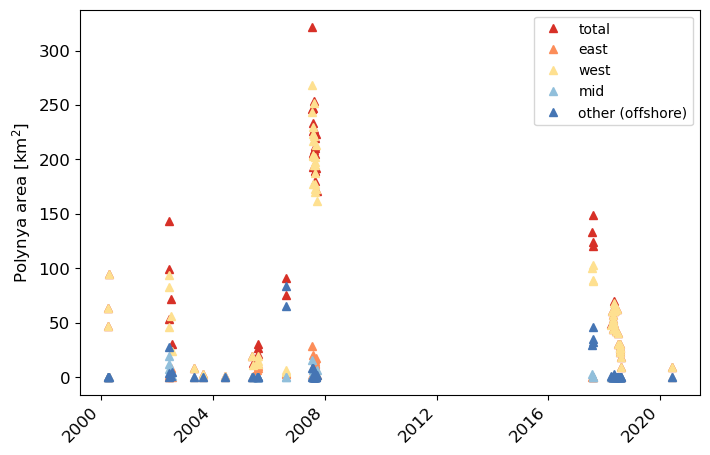

In [655]:
# will need to save compiled df as pickle file after happy w algorithm so that don't need to rerun (so long)

# Example fig

plt.figure(figsize=(8,5))
plt.plot(df_concat['Date'],df_concat['total'], '^',label='total',c='#d73027',linewidth= 1, markersize = 6)
plt.plot(df_concat['Date'],df_concat['east'], '^',label='east', c = '#fc8d59',linewidth= 1, markersize = 6)
plt.plot(df_concat['Date'],df_concat['west'], '^',label='west',c = '#fee090',linewidth= 1, markersize = 6)
plt.plot(df_concat['Date'],df_concat['mid'], '^',label='mid',c='#91bfdb',linewidth= 1, markersize = 6)
plt.plot(df_concat['Date'],df_concat['other'], '^',label='other (offshore)',c ='#4575b4',linewidth= 1, markersize = 6) # this will be closely linked to calving!!!!
plt.ylabel('Polynya area [$\mathregular{km^{2}}$]',fontsize=12)#,plt.xlabel('Date',fontsize=15)
plt.legend(fontsize=10,loc='best')
plt.yticks(fontsize=12)
plt.xticks(rotation=45, ha='right',fontsize=12)
#plt.ylim([-1,10])
#plt.gca().invert_xaxis()

plt.show()

## Save as pickle file for all subsequent visualization and figures
in directory where all figure will be made

In [656]:
pwd

'/Users/elenasavidge/Documents/Documents - Elena’s MacBook Pro/PhD_Ch2/polynyatimeseries'

In [657]:
df_concat.to_pickle("../manuscriptcode_2/thermal_area_effectivepixel_fixed") 